# 🔎📊🧩 **Exploratory Data Analysis (EDA)**

<img src="./assets/eda_banner.jpg" style="width:75%">

*Estimated run time: 2min*

This notebook provides a comprehensive and structured exploration of the dataset to uncover patterns, trends, and insights that influence customer no-show behavior at the hotel chain. The analysis is designed to guide feature engineering, preprocessing, and modeling decisions, ensuring a robust and interpretable machine learning pipeline.

To ensure clarity, consistency, and ease of navigation, the following intuitive indicators have been adopted to categorize and guide the reader through the various stages of the analysis:

- **⬜ General Steps**: Foundational tasks like loading, inspecting, and preparing the dataset for analysis.

- **📊 Analytical Procedures**: Statistical tests, visualizations, and exploratory techniques to uncover patterns and relationships.

- **💡 Key Insights**: Key findings and hypotheses driving feature engineering and modeling decisions.

- **🧼 Data Cleaning**: Handling missing values, outliers, and inconsistencies to ensure data accuracy.

- **🛠️ Feature Engineering**: Creating and selecting features to improve model performance and interpretability.

- **⚠️ Alerts**: Notes or warnings highlighting potential issues and their implications.

---
---
---
# 🎯 **1. Introduction** 

The primary objective of this project is to predict customer no-shows for a hotel chain using the provided dataset. A no-show occurs when a customer makes a booking but fails to arrive, leading to revenue loss and operational inefficiencies. By accurately predicting no-shows, this analysis aims to empower the hotel chain to implement data-driven policies that minimize costs and improve resource allocation.

This Exploratory Data Analysis (EDA) serves as the foundation for understanding customer behavior and identifying key factors contributing to no-shows. Through systematic exploration of the dataset, we aim to uncover actionable insights that will inform feature engineering, preprocessing, and model selection in the machine learning pipeline.

Our EDA is structured around three core areas:

- **Data Overview**:

  - Examine the structure, characteristics, and quality of the dataset.

  - Identify and handle missing values, outliers, and potential issues such as synthetic features or class imbalance.

  - Ensure that the dataset is clean and reliable for modeling.

- **Feature Analysis**:

  - Investigate relationships between features and the target variable.

  - Analyze distributions, correlations, and interactions among features to identify predictive signals.

  - Highlight variables that significantly influence no-show rates, such as booking details, customer demographics, and room preferences.

- **Pattern Recognition**:

  - Discover trends and behavioral patterns that could inform strategies to reduce no-shows.

  - Uncover the most influential factors contributing to no-show behavior, such as booking patterns, customer demographics, or operational variables.

  - Group customers based on shared characteristics or behaviors to tailor targeted interventions and improve predictive accuracy.

The insights gained from this EDA will directly inform the design of the end-to-end machine learning pipeline, ensuring that the models developed are robust, interpretable, and aligned with business objectives.

---
---
---
# 🤔 **2. Preliminary Understanding** 

Before analyzing the data, we establish **initial hypotheses** and define **key areas for investigation** based on the dataset's attributes. These hypotheses will guide our EDA and ensure a systematic approach to uncovering insights.

---
**📜 Initial Hypotheses**

**1. Identifier:** `booking_id`

   - A unique identifier for each booking.
   
   - Reason to Exclude:
   
     - If generated chronologically (e.g., incrementally over time), it could introduce temporal leakage, creating unintended patterns that affect data splitting (e.g., training vs. testing sets) and lead to overly optimistic performance estimates.

     - Provides no predictive value and should be excluded from modeling.

**2. Target Variable:** `no_show`

   - Indicates whether a customer is a no-show (1) or not (0).

   - The primary variable to predict in this analysis. Understanding its relationship with other features is critical for reducing no-show rates.

**3. Temporal Trends:** `booking_month`, `arrival_month`, `arrival_day`, `checkout_month`, `checkout_day`

   - Longer gaps between 'booking_month' and 'arrival_month' may reduce no-shows, as customers have more time to plan and commit.
   
   - Longer stays (calculated from 'arrival_day' and 'checkout_day') might indicate better planning and commitment, reducing no-show likelihood.

   - Last-minute bookings ('booking_month' close to 'arrival_month') might increase no-show rates due to uncertainty or cancellations.

   - Day-level granularity ('arrival_day', 'checkout_day') may add noise unless aggregated into broader categories like weekends or weekdays.

**4. Customer Demographics:** `first_time`, `country`, `num_adults`, `num_children`
 
   - First-time customers ('first_time') may have higher no-show rates compared to returning customers, as they might be less familiar with the hotel’s policies.

   - Customers from specific countries ('country') might exhibit different no-show behaviors, influenced by travel restrictions, cultural preferences, or booking habits.

   - Larger groups ('num_adults', 'num_children') may show lower no-show rates, as organizing group travel involves significant planning and commitment.

**5. Booking Details:** `branch`, `room`, `price`, `platform`
   
   - Different hotel branches ('branch') may exhibit varying no-show rates due to factors like location, reputation, or customer demographics.

   - Certain room types ('room') may attract different customer segments, influencing no-show behavior. For example, luxury rooms might correlate with lower no-show rates.

   - Higher room prices ('price') might discourage no-shows, as customers are less likely to forfeit expensive bookings.

   - Bookings made through third-party platforms ('platform') might see higher no-show rates compared to direct bookings, as customers may feel less accountability.

---
**📌 Key Areas for Investigation**

- Do seasonal trends (`arrival_month`) affect no-show rates?

- How does the price of the room (`price`) influence no-show behavior?

- How does booking lead time (`booking_month` vs. `arrival_month`) impact no-show likelihood?

- Are certain platforms (`platform`) or room types (`room`) associated with higher no-show rates?

- What role do customer demographics (`country`, `first_time`) and group size (`num_adults`, `num_children`) play?

---
---
---
# 📦 **3. Import Dependencies & Setup** 

---
**⬜ Import general libraries**

In [1]:
import os
import yaml
import requests

---
**⬜ Import and configure data libraries**

In [2]:
import sqlite3
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

np.random.seed(42)  # Seed value for numpy.random for reproducibility

pd.set_option('max_colwidth', 40)  # Set the maximum width of each column to 40 characters for better readability
pd.options.display.max_columns = None   # Display all columns in the output (instead of truncating them with "..." for wide DataFrames)
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Limit float precision for cleaner output

---
**⬜ Import and configure plotting libraries**

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import missingno as msno

# Use ggplot style for plots with a clean, professional look
plt.style.use('ggplot')  

# # Remove the spines (borders) of plots for a minimalist design
rcParams['axes.spines.right'] = False  # Remove the right spines (border) for a minimalist design
rcParams['axes.spines.top'] = False  # Remove the top spines (border) for a minimalist design
rcParams['figure.figsize'] = [12, 9]  # Set default figure size

%config InlineBackend.figure_format = 'retina'  # Enhance plot resolution for high-quality rendering on Retina displays

---
**⬜ Import custom functions**

In [4]:
# Utility functions
from src.utils.analyse_missing_values import analyse_missing_values
from src.utils.compare_dataframes import compare_dataframes
from src.utils.perform_univariate_analysis import perform_univariate_analysis
from src.utils.perform_bivariate_analysis import perform_bivariate_analysis
from src.utils.perform_multivariate_analysis import perform_multivariate_analysis

---
**⬜ Configure notebook interactivity**

In [5]:
import warnings
from IPython.core.interactiveshell import InteractiveShell

# Configure IPython to display all expressions in a cell, not just the last one
# InteractiveShell.ast_node_interactivity = 'all'  # Postpone until after data download to avoid excessive outputs

# Hides warnings like deprecation notices or convergence warnings
warnings.filterwarnings('ignore')

# Disable Jedi autocompletion in IPython for faster tab completion
%config Completer.use_jedi = False  

---
**⬜ Get configurations from `config.yaml`**

In [6]:
# Define the config file
CONFIG_FILE = "config.yaml"

# Load the configuration file
try:
    with open(CONFIG_FILE, "r") as f:
        config = yaml.safe_load(f)

        # Extract config
        DATA_URL = config.get("data_url")
        DB_PATH = config.get("db_path")
        DB_TABLE_NAME = config.get("db_table_name")
        TARGET = config.get("target")
        TEST_SIZE = config.get("test_size")
        RANDOM_STATE = config.get("random_state")

        print(f"✅ Config loaded successfully.")

except FileNotFoundError:
    raise FileNotFoundError("❌ Configuration file 'config.yaml' not found.")

# Validate configuration
if not DATA_URL or not DB_PATH or not DB_TABLE_NAME or not TARGET or not TEST_SIZE or not RANDOM_STATE:
    raise ValueError("❌ Missing constants in the configuration file. Please check the config.yaml file.")

✅ Config loaded successfully.


---
---
---
# ⏬ **4. Load Data** 

This section will perform the following tasks: 

- Establish a connection to the SQLite database and retrieve the `noshow` table into a Pandas DataFrame.

- Utilize a context manager to ensure proper error handling and resource cleanup.

- Load the dataset into memory as a Pandas DataFrame, preparing it for EDA.

---
**⬜ Download the dataset (if not already downloaded)**

In [7]:
# Ensure the 'data' directory exists
os.makedirs(os.path.dirname(DB_PATH), exist_ok=True)

# Check if the file exists locally
if os.path.exists(DB_PATH):
    print("✅ File already exists.")
else:
    print("⚠️ File not found. Downloading...")
    try:
        # Download the file
        response = requests.get(DATA_URL, stream=True)
        response.raise_for_status() 
        
        with open(DB_PATH, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        print(f"✅ File downloaded successfully: {DB_PATH}")
    except requests.RequestException as e:
        print(f"❌ Error downloading the file: {e}")

✅ File already exists.


In [8]:
# Display all expressions in a cell, not just the last one
InteractiveShell.ast_node_interactivity = 'all'

---
**⬜ Load dataset into Pandas DataFrame**

In [9]:
try:
    # Dynamically use the table name from the configuration
    table_name = DB_TABLE_NAME

    # Establish a connection to the SQLite database and load the table into a DataFrame.
    with sqlite3.connect(DB_PATH) as conn:
        query = f"SELECT * FROM {table_name}"
        df = pd.read_sql_query(query, conn)
    
    print("✅ Data loaded, connection closed.")
except sqlite3.Error as e:
    print(f"❌ Database error: {e}")

✅ Data loaded, connection closed.


---
**📊 Display the shape of the DataFrame to confirm loading and understand its size**

In [10]:
df.shape  # Displays the dimensions of the DataFrame (i.e. number of rows and columns)

(15900, 18)

---
---
---
# 🔎 **5. Basic Exploration** 

This section focuses on gaining an initial understanding of the dataset through various exploratory techniques. By examining the structure, content, and quality of the data, we aim to identify key characteristics, potential issues, and areas requiring further investigation. The steps include:

- **Inspecting Rows**: Understand the dataset's structure and variability.

- **Assessing Data Quality**: Identify missing values and evaluate data completeness.

- **Summarizing Metadata**: Review column names, data types, and non-null counts, ensuring a clear understanding of the dataset's composition.

- **Analyzing Numerical Statistics**: Examine central tendencies, variability, and ranges of numerical features, highlighting potential outliers or anomalies.

These foundational steps provide a comprehensive overview of the dataset, guiding subsequent analysis and preprocessing decisions.

---
---
## 🔎 **5.1. Inspect Rows**

This section involves examining specific subsets of rows from the dataset to gain an initial understanding of its structure, content, and overall organization. By reviewing different parts of the dataset, we aim to:

- Gain an initial understanding of how data is organized within the dataset.

- Identify any immediate patterns, anomalies, or inconsistencies that may require further investigation.

- Verify that the data has been loaded correctly and matches expectations.

These inspections provide a starting point for deeper analysis and help guide subsequent steps in the exploratory process.

---
**📊 Display First Few Rows with `df.head()`**

- Provides an initial glimpse of the data structure, column names, and sample values.

- Helps verify data loading and understand basic patterns or formats in the dataset.

In [11]:
df.head()  

index  number_of_siblings direct_admission     CCA learning_style  \
0      0                   0              Yes  Sports         Visual   
1      1                   2               No  Sports       Auditory   
2      2                   0              Yes    None         Visual   
3      3                   1               No   Clubs       Auditory   
4      4                   0               No  Sports       Auditory   

  student_id  gender tuition  final_test  n_male  n_female    age  \
0     ACN2BE  Female      No      69.000  14.000     2.000 16.000   
1     FGXIIZ  Female      No      47.000   4.000    19.000 16.000   
2     B9AI9F    Male      No      85.000  14.000     2.000 15.000   
3     FEVM1T  Female     Yes      64.000   2.000    20.000 15.000   
4     AXZN2E    Male      No      66.000  24.000     3.000 16.000   

   hours_per_week  attendance_rate sleep_time wake_time  mode_of_transport  \
0          10.000           91.000      22:00      6:00  private transport   
1           7.000           94.000      22:30      6:30  private transport   
2           8.000           92.000      22:30      6:30  private transport   
3          18.000              NaN      21:00      5:00   public transport   
4           7.000           95.000      21:30      5:30   public transport   

  bag_color  
0    yellow  
1     green  
2     white  
3    yellow  
4    yellow

💡 **Column Headers**: All column headers are in snake_case, which is ideal for referencing and consistency. No changes required.

💡 **`Price` Column**:

- Includes `SGD$` and `USD$` prefixes (potentially others as well) ➡️ to standardise the currency and remove prefixes to ensure that the data is clean and ready for numerical analysis.

- Contains `None` values (potentially others as well) as missing values ➡️ need to be addressed later, either by imputation, removal, or another appropriate method.

💡 **Preliminary Hypothesis**:

- Based on logical reasoning, certain features can be removed from the dataset due to irrelevance, redundancy, or lack of predictive power. The criteria for removal are as follows:

  - Irrelevance : Features that logically do not contribute to understanding patient no-show behavior (e.g., IDs or unrelated metadata).
  - Redundancy : Features that logically provide duplicate information or are highly correlated with other features.
  - Lack of Predictive Power : Features that, based on logical analysis, show little to no impact on predicting no-show events.

- Potential Features to Remove:

  - `booking_id`: Acts as a unique identifier and does not contribute to predicting no-show behavior.


---
**📊 Display Last Few Rows with `df.tail()`**

- Provides a glimpse of the ending records, helping to identify patterns or anomalies toward the end of the dataset.

- Ensures completeness of the data and verifies that all records are loaded correctly.

In [12]:
df.tail()  

index  number_of_siblings direct_admission     CCA learning_style  \
15895  15895                   1               No   Clubs         Visual   
15896  15896                   1              Yes    None       Auditory   
15897  15897                   1              Yes  Sports       Auditory   
15898  15898                   1               No   Clubs         Visual   
15899  15899                   2              Yes    None         Visual   

      student_id  gender tuition  final_test  n_male  n_female    age  \
15895     XPECN2  Female      No      56.000  12.000    14.000 16.000   
15896     7AMC7S    Male     Yes      85.000  17.000     5.000 16.000   
15897     XKZ6VN  Female     Yes      76.000   7.000    10.000 15.000   
15898     2OU4UQ    Male     Yes      45.000  18.000    12.000 16.000   
15899     D9OKLV    Male      No      87.000  11.000     7.000 16.000   

       hours_per_week  attendance_rate sleep_time wake_time  \
15895           9.000           96.000      22:00      6:00   
15896           7.000           91.000      22:30      6:30   
15897           7.000           93.000      23:00      7:00   
15898           3.000           94.000      23:00      7:00   
15899           9.000           91.000      23:00      7:00   

       mode_of_transport bag_color  
15895  private transport     black  
15896  private transport     white  
15897               walk       red  
15898               walk    yellow  
15899               walk    yellow

**💡 Possible Duplicate / Error `booking_id`**

- The last index is 119,390, but the first few entries are not in sequential order.
- To check data later for possible duplicates / some other error, or simply a recording inconsistency which will not be an issue.

---
**📊 Display Random Samples with `df.sample()`**

- Provides an unbiased glimpse of the dataset’s structure and content, ensuring that the sample is not limited to the first or last rows.

- Helps identify patterns, anomalies, or inconsistencies that may not be visible in sequential rows.

In [13]:
df.sample(5, random_state=2508)  # Add random_state for reproducibility

index  number_of_siblings direct_admission     CCA learning_style  \
3773   3773                   0               No    None       Auditory   
928     928                   0               No    ARTS       Auditory   
9081   9081                   0               No   Clubs       Auditory   
3861   3861                   1               No  Sports       Auditory   
2743   2743                   2               No    Arts       Auditory   

     student_id  gender tuition  final_test  n_male  n_female    age  \
3773     66YK1R    Male     Yes      94.000  17.000     4.000 16.000   
928      OOPZWX  Female      No      64.000   8.000    19.000 15.000   
9081     49F7S6    Male     Yes      77.000  16.000     5.000 16.000   
3861     PRK0SJ    Male      No      54.000  23.000     2.000 16.000   
2743     NNFIKF    Male      No      62.000  12.000    11.000 15.000   

      hours_per_week  attendance_rate sleep_time wake_time  mode_of_transport  \
3773           7.000           96.000      22:30      6:30  private transport   
928            6.000           94.000      22:30      6:30  private transport   
9081           8.000           99.000      23:00      7:00               walk   
3861          19.000          100.000      21:00      5:00   public transport   
2743           8.000           93.000      22:30      6:30  private transport   

     bag_color  
3773      blue  
928      black  
9081     white  
3861       red  
2743     black

💡 **`num_adults` Column**:
- Inconsistent data types detected. (May not be shown when replicated due to sampling)
- Some values are numerical (e.g., `1`), while others are represented as text (e.g., `"one"`). 
- This inconsistency should be addressed by standardizing the format, either converting all values to numerical or textual representation.

---
---
## 🔎 **5.2. DataFrame Summary**

- Display a summary of the DataFrame, including column names, data types, and non-null counts.

- Provides an overview of the dataset's structure, helping to identify missing values and verify data types.

- Ensures all columns are correctly formatted and highlights potential issues that may require cleaning or preprocessing.

---
**📊 DataFrame summary with `df.info()`**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900 entries, 0 to 15899
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               15900 non-null  int64  
 1   number_of_siblings  15900 non-null  int64  
 2   direct_admission    15900 non-null  object 
 3   CCA                 15900 non-null  object 
 4   learning_style      15900 non-null  object 
 5   student_id          15900 non-null  object 
 6   gender              15900 non-null  object 
 7   tuition             15900 non-null  object 
 8   final_test          15405 non-null  float64
 9   n_male              15900 non-null  float64
 10  n_female            15900 non-null  float64
 11  age                 15900 non-null  float64
 12  hours_per_week      15900 non-null  float64
 13  attendance_rate     15122 non-null  float64
 14  sleep_time          15900 non-null  object 
 15  wake_time           15900 non-null  object 
 16  mode

💡 **DataFrame Size**:

   - The DataFrame contains **119,391 rows** and **15 columns**, indicating a moderately sized dataset.

   - The DataFrame consumes **13.7+ MB** of memory, which is reasonable given its size.

💡 **Incorrect Data Types**:

   - The target variable `no_show` is currently as type float64, which is technically correct, but these column should be mapped to categorical values (i.e.1 = Yes and 0 = No) as type object for classification purposes.

   - `price` and `num_adults` are as type objects, but should be converted to float64 and int64 respectively instead

---
---
## 🔎 **5.3. DataFrame Statistics**

- Use `df.describe()` to generate summary statistics for numerical columns in the DataFrame.

- Provides insights into central tendencies (mean, median), variability (standard deviation), and ranges (min, max) of numerical features.

- Helps identify potential issues such as outliers, skewness, or unrealistic values in the data.

---
**📊 Summary statistics with `df.describe()`**

In [15]:
# Display in normal notation instead of scientific
with pd.option_context('float_format', '{:f}'.format):
    # Include all columns in the summary statistics
    df.describe(include='all')

index  number_of_siblings direct_admission    CCA  \
count  15900.000000        15900.000000            15900  15900   
unique          NaN                 NaN                2      8   
top             NaN                 NaN               No  Clubs   
freq            NaN                 NaN            11195   3912   
mean    7949.500000            0.886541              NaN    NaN   
std     4590.078975            0.751346              NaN    NaN   
min        0.000000            0.000000              NaN    NaN   
25%     3974.750000            0.000000              NaN    NaN   
50%     7949.500000            1.000000              NaN    NaN   
75%    11924.250000            1.000000              NaN    NaN   
max    15899.000000            2.000000              NaN    NaN   

       learning_style student_id gender tuition   final_test       n_male  \
count           15900      15900  15900   15900 15405.000000 15900.000000   
unique              2      15000      2       4          NaN          NaN   
top          Auditory     I9NYBE   Male     Yes          NaN          NaN   
freq             9132          2   7984    8669          NaN          NaN   
mean              NaN        NaN    NaN     NaN    67.165401    13.880000   
std               NaN        NaN    NaN     NaN    13.977879     6.552584   
min               NaN        NaN    NaN     NaN    32.000000     0.000000   
25%               NaN        NaN    NaN     NaN    56.000000    10.000000   
50%               NaN        NaN    NaN     NaN    68.000000    14.000000   
75%               NaN        NaN    NaN     NaN    78.000000    18.000000   
max               NaN        NaN    NaN     NaN   100.000000    31.000000   

           n_female          age  hours_per_week  attendance_rate sleep_time  \
count  15900.000000 15900.000000    15900.000000     15122.000000      15900   
unique          NaN          NaN             NaN              NaN         13   
top             NaN          NaN             NaN              NaN      23:00   
freq            NaN          NaN             NaN              NaN       3131   
mean       8.906038    15.213459       10.312579        93.270268        NaN   
std        6.663852     1.758941        4.461861         7.984230        NaN   
min        0.000000    -5.000000        0.000000        40.000000        NaN   
25%        4.000000    15.000000        7.000000        92.000000        NaN   
50%        8.000000    15.000000        9.000000        95.000000        NaN   
75%       13.000000    16.000000       14.000000        97.000000        NaN   
max       31.000000    16.000000       20.000000       100.000000        NaN   

       wake_time mode_of_transport bag_color  
count      15900             15900     15900  
unique         5                 3         6  
top         5:00  public transport    yellow  
freq        3246              6371      2731  
mean         NaN               NaN       NaN  
std          NaN               NaN       NaN  
min          NaN               NaN       NaN  
25%          NaN               NaN       NaN  
50%          NaN               NaN       NaN  
75%          NaN               NaN       NaN  
max          NaN               NaN       NaN

**💡 Check for Possible Duplicates for `booking_id`** 

   - If complete duplicates (all other values are identical), remove them.

   - If duplicates have different values, clarify with the data collector.

   - If clarification is not possible:
     - Remove entries with incomplete values.
     - Alternatively, retain the most recent entry (prioritizing "show" over "no-show").

**💡 Mean for `no_show` is 0.37**

   - Approximately 63% of customers show up (value = 0) and 37% do not show up (value = 1).

**💡 Invalid Values for `checkout_day`** 

   - The minimum value is -31, which is invalid as the day of the month cannot be negative. 
   
   - This could be an error during data collection.

   - Verify with the data collector if this is a mistake. If confirmed as an error, take the absolute value (abs(`checkout_day`)).

   - If clarification is not possible:
     - Count occurrences of negative values.
     - If the occurrences are minimal relative to the dataset size, consider removing these entries.

**💡 Invalid Data Types for `Price` and `num_adults`**

   - These columns need to be cleaned and converted to numerical formats for further analysis.
   
   - Investigate and resolve formatting inconsistencies before proceeding with statistical analysis or modeling.

---
---
## 🔎 **5.4. Analyze Missing Values**

- Use `missingno` package and `df.isnull().sum()` to visualise and count the number of missing values in each column.

- Identifies columns with missing data, helping to assess data quality and plan for cleaning or imputation.

- Provides insights into potential issues that could affect analysis or modeling if not addressed.

Understanding missing values is critical to assess data quality and determine appropriate strategies for handling them, such as:

- **Removal**: Dropping rows or columns with excessive missing values.

- **Imputation**: Filling missing values using statistical methods (e.g., mean, median), predictive models or domain specific knowledge.

- **Flagging**: Create a binary indicator column to flag whether a value was originally missing. This approach retains information about the presence of missingness, which might be meaningful.

- **Synthetic Data Generation**: Generate synthetic data to fill in missing values. This is more advanced and typically used when the dataset is small or highly sensitive to missingness.

- **No Action**: If the proportion of missing values is negligible (e.g., <1%), it may be acceptable to leave them as-is, especially if the machine learning model can handle missing values (e.g., XGBoost, LightGBM)

Identifying patterns in missingness can also reveal underlying issues in data collection or preprocessing.

---
**📊 Calculate the total number of missing values per column**

- Use `df_cleaned.isnull().sum()`

- Quantifies the extent of missing data for each feature

In [16]:
df.isnull().sum()

index                   0
number_of_siblings      0
direct_admission        0
CCA                     0
learning_style          0
student_id              0
gender                  0
tuition                 0
final_test            495
n_male                  0
n_female                0
age                     0
hours_per_week          0
attendance_rate       778
sleep_time              0
wake_time               0
mode_of_transport       0
bag_color               0
dtype: int64

💡 **Missing Values**:

   - 12 features have 1 missing values each: `no_show`, `branch`, `booking_month`, `arrival_month`, `arrival_day`, `checkout_month`, `checkout_day`, `country`, `first_time`, `platform`, `num_adults`, `num_children` ➡️ Need to check if these are all from the same row or from different rows

   - `room` has 21,613 missing values

   - `price` has 24,882 missing values

---
**📊 Visualize the distribution of missing values across the DataFrame**

- Use `msno.matrix(df)`

- Missing values are displayed as white lines in the matrix

<Axes: >

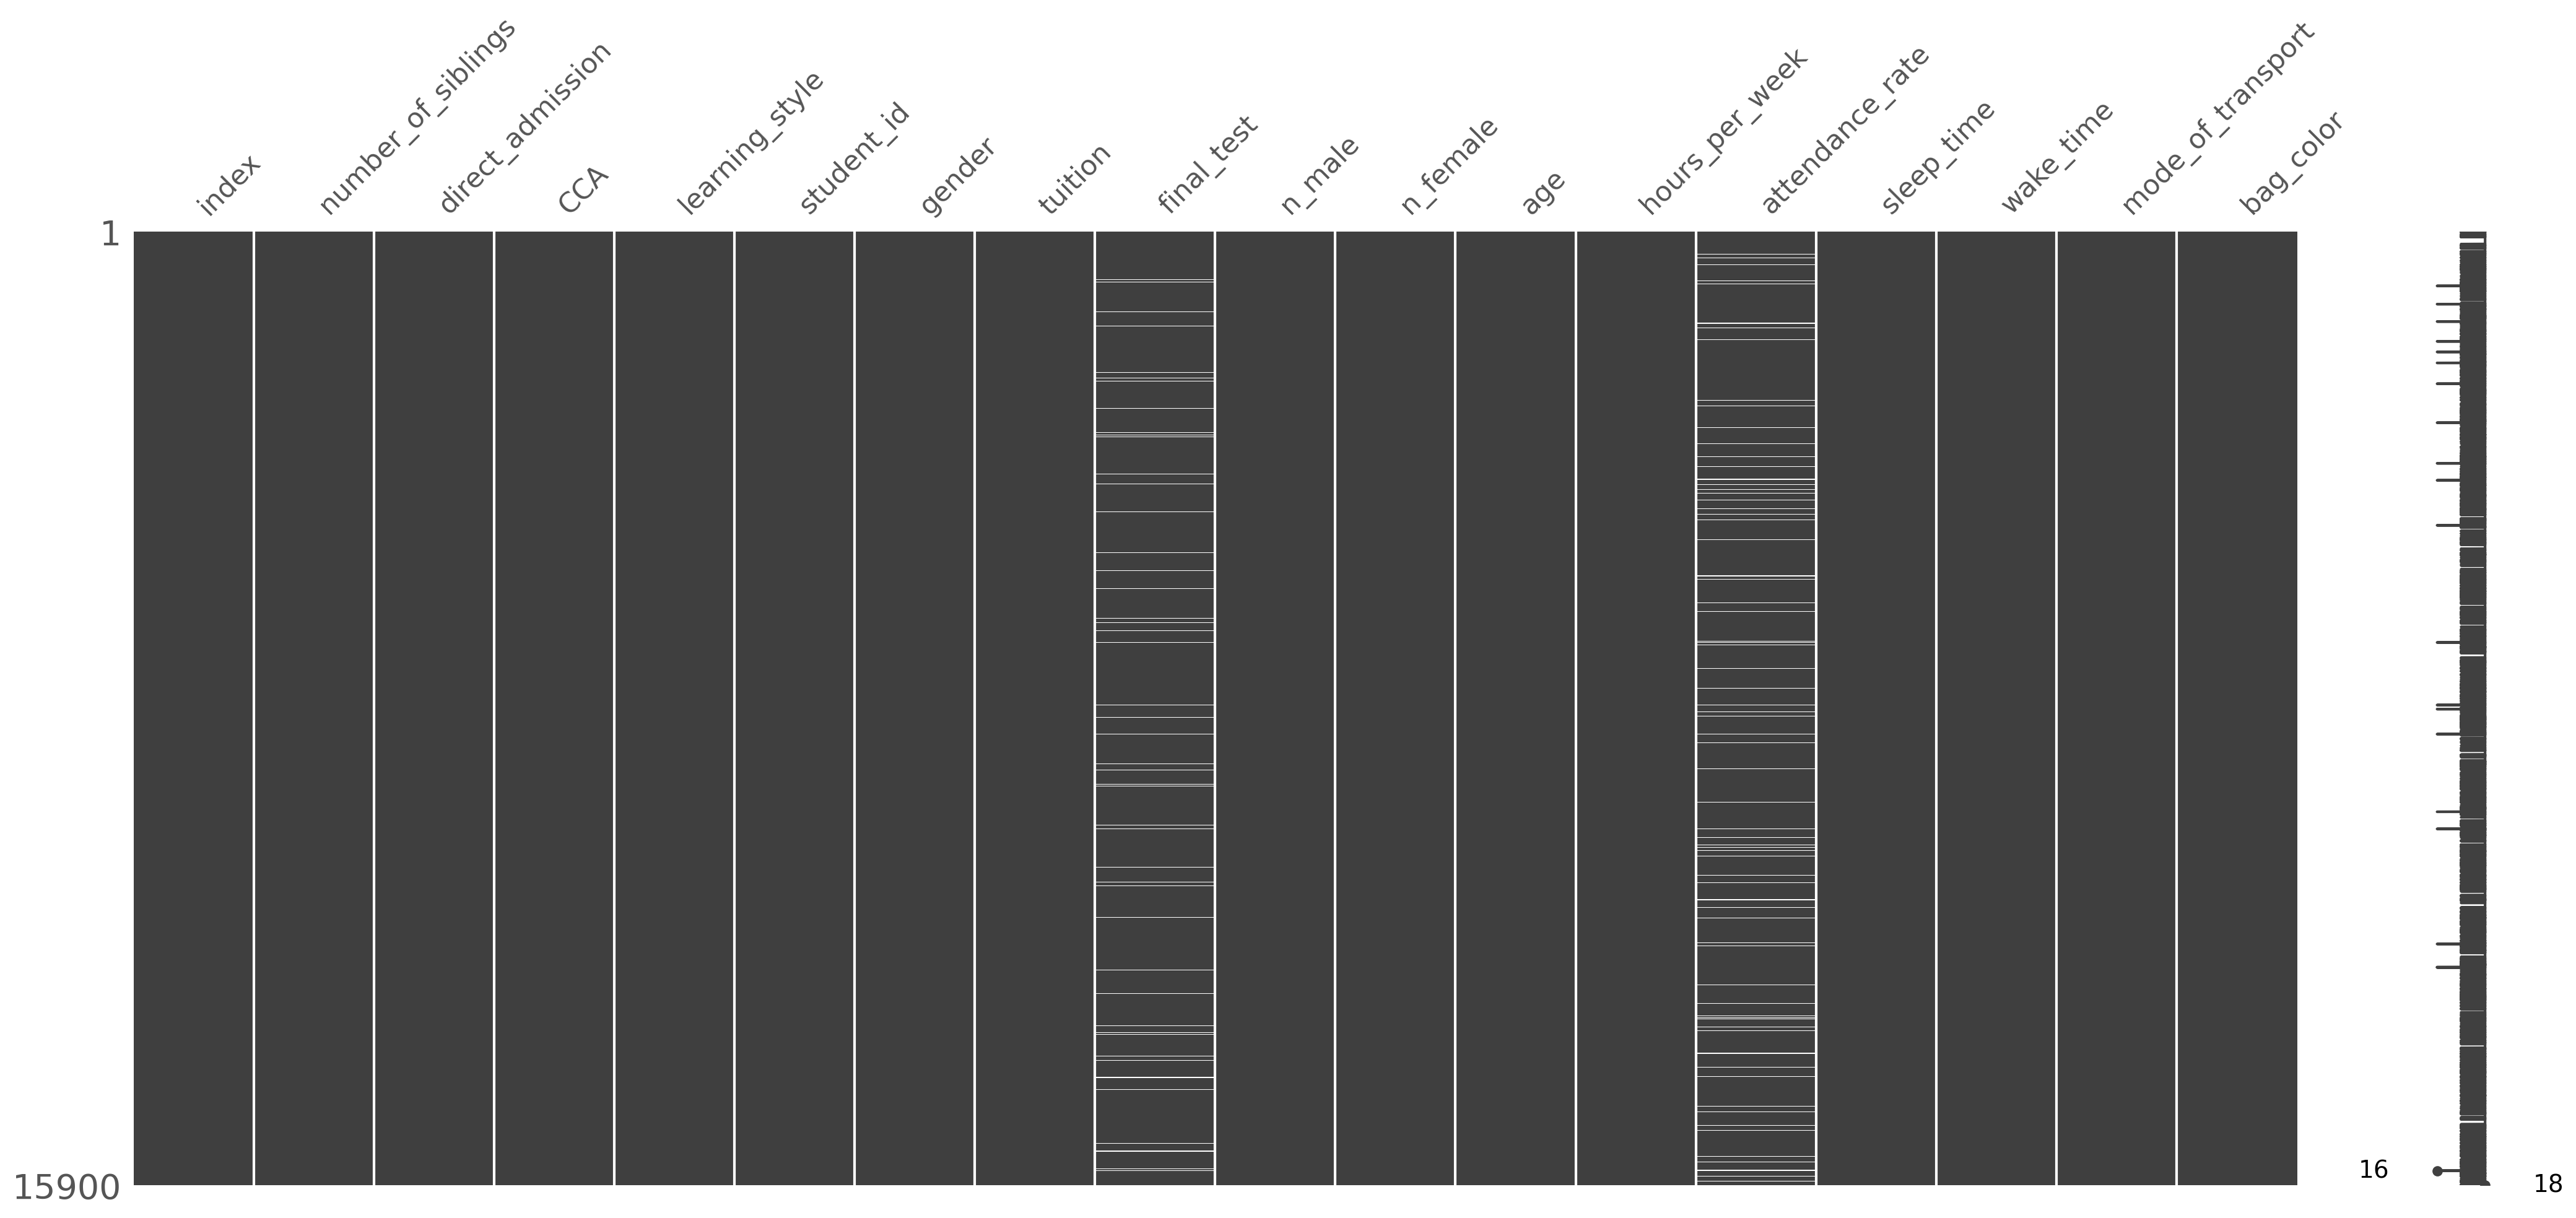

In [17]:
msno.matrix(df)  # Missing values are displayed as white lines in the matrix

---
**📊 Visualize the correlation of missing values across different columns the DataFrame**

- Use `msno.matrix(df)`

- The heatmap shows the patterns of missingness in your dataset to help identify systematic issues in data collection or preprocessing.

- It helps identify whether missing values in one column are correlated with missing values in other columns.

<Axes: >

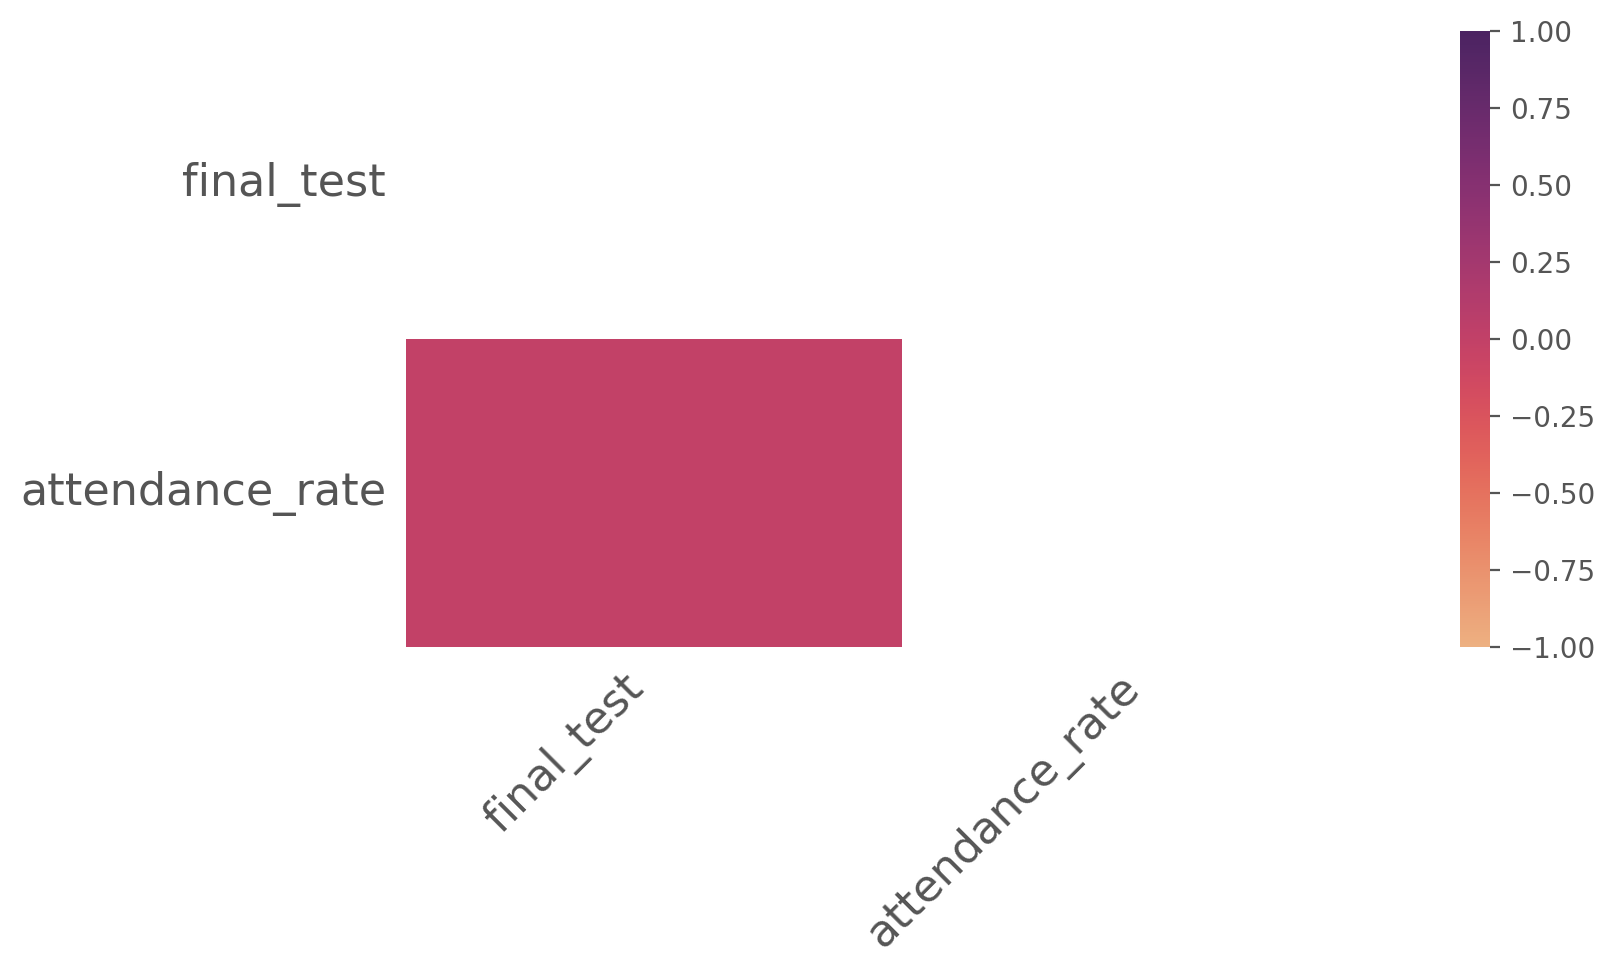

In [18]:
# Visualize correlation between missing values
msno.heatmap(df[['final_test', 'attendance_rate']], figsize=(8, 4), cmap='flare')

💡 Weak negative correlation between `room` and `price`

- The correlation coefficient of -0.2.
- While this correlation is statistically detectable, its practical significance is low, meaning these variables are largely independent.

---
---
## 🔎 **5.5. AutoEDA**

**Purpose:**

- This section utilizes the `ydata-profiling` library to perform **Automated Exploratory Data Analysis (AutoEDA)**.

- The profiling report provides a comprehensive, interactive overview of the dataset, allowing for seamless exploration of the dataset, making it easier to identify trends, outliers, and relationships. This modern AutoEDA workflow complements the manual analysis conducted throughout this notebook.

- While the profiling report serves as a valuable tool for preliminary analysis, it is used in conjunction with deeper, domain-specific exploration and visualizations presented in subsequent sections of this notebook.

**Key Features:**

Generates an interactive HTML report that can be explored directly in your browser or within this notebook.

- Highlights critical aspects of the data, including:
    - Descriptive statistics (mean, median, standard deviation, etc.);
    - Missing values and their distribution;
    - Correlations between features; and
    - Data types, unique values, and potential issues like high cardinality or imbalanced features.

- Provides alerts for potential data quality issues, such as highly correlated features or excessive missing values.

**⚠️ Important Note:**

Although the code has been tested across multiple environments, compatibility issues may arise due to differences in system configurations or dependencies. If you encounter any errors while running the code below or subsequent codes, please comment out the code in this section and rerun the notebook. The profiling report is intended to assist in the initial analysis but is not critical to the overall findings of this EDA.

---
**📊 Generate a profiling report**

In [19]:
# Create a profile report
profile = ProfileReport(df, title="Profiling Report")

# Render the profiling report directly in the notebook
profile.to_notebook_iframe()

# To avoid plotting issues after running the above library
%matplotlib inline

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:00<00:00, 439.80it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---
---
---
# 🧼 **6. Data Cleaning**

Data cleaning is a foundational step in any data analysis or machine learning pipeline. It ensures the dataset is **accurate**, **consistent**, and **reliable**, enabling meaningful exploration and modeling. Raw datasets often contain issues such as missing values, incorrect data types, irrelevant features, or inconsistencies that can distort insights and compromise model performance. By addressing these issues systematically, we create a robust foundation for EDA and subsequent modeling.

Univariate analysis plays a critical role in this phase, serving as a cornerstone for understanding individual features.

In this section, we focus on identifying and resolving potential issues to prepare the dataset for thorough exploration. This process includes:

- Checking for duplicate rows.

- Removing or addressing irrelevant or redundant features.

- Handling missing values (if too many, impute with placeholder first and address in later sections).

- Correcting data types and addressing inconsistencies.

- Identifying and mitigating potential sources of bias.

While minimal cleaning is performed here to facilitate EDA, advanced preprocessing steps—such as feature engineering, scaling, and outlier removal—will be deferred to later stages of the pipeline, where decisions can be informed by relationships between features.

***⚠️ Note**: Advanced cleaning steps, such as removing outliers or applying complex transformations, will be addressed in later sections ONLY after data splitting to avoid data leakage and where they can be guided by bivariate and multivariate insights.*

In [20]:
from src.clean_data import clean_data

In [21]:
# Create copy of DataFrame
df_cleaned = df.copy()

---
---
## 🧼 **6.1. Check for Duplicates**

- Identify duplicate entries in the DataFrame.

- Verify the uniqueness of the `booking_id` column to ensure each booking has a unique identifier, as expected.

---
**📊 Check for duplicate rows in the DataFrame**

In [22]:
duplicate_rows = df_cleaned[df_cleaned.duplicated(keep=False)]
duplicate_rows

Empty DataFrame
Columns: [df_index, number_of_siblings, direct_admission, CCA, learning_style, student_id, gender, tuition, final_test, n_male, n_female, age, hours_per_week, attendance_rate, sleep_time, wake_time, mode_of_transport, bag_color]
Index: []

---
**📊 Count unique booking IDs in the original DataFrame**

In [23]:
unique_student_id = df_cleaned['student_id'].nunique() 
unique_student_id

15000

In [24]:
student_id_counts = df_cleaned['student_id'].value_counts()
student_id_counts[student_id_counts > 1]  # Show only IDs with duplicates

student_id
I9NYBE    2
TP28JA    2
AXZN2E    2
6K37P0    2
UCYK4W    2
         ..
3YP8F0    2
1FKAEF    2
T4U89N    2
G0JBVS    2
HJ6Y5P    2
Name: count, Length: 900, dtype: int64

In [25]:
df_cleaned[df_cleaned['student_id'] == 'HJ6Y5P']  

df_index  number_of_siblings direct_admission   CCA learning_style  \
21          21                   0               No  None         Visual   
7981      7981                   0               No  None         Visual   

     student_id gender tuition  final_test  n_male  n_female    age  \
21       HJ6Y5P   Male     Yes      86.000  17.000     6.000 16.000   
7981     HJ6Y5P   Male     Yes      86.000  17.000     6.000 16.000   

      hours_per_week  attendance_rate sleep_time wake_time  mode_of_transport  \
21             8.000           91.000      23:30      6:30  private transport   
7981           8.000           91.000      23:30      6:30  private transport   

     bag_color  
21         red  
7981    yellow

In [26]:
df_cleaned = df_cleaned.drop_duplicates(subset='student_id', keep='last') # Keep last assuming that it is an update thing, so most recent entry is the one to keep

In [27]:
student_id_counts = df_cleaned['student_id'].value_counts()
student_id_counts[student_id_counts > 1]  # Show only IDs with duplicates

Series([], Name: count, dtype: int64)

In [28]:
df_cleaned

df_index  number_of_siblings direct_admission     CCA learning_style  \
0             0                   0              Yes  Sports         Visual   
1             1                   2               No  Sports       Auditory   
2             2                   0              Yes    None         Visual   
3             3                   1               No   Clubs       Auditory   
5             5                   0               No    Arts         Visual   
...         ...                 ...              ...     ...            ...   
15895     15895                   1               No   Clubs         Visual   
15896     15896                   1              Yes    None       Auditory   
15897     15897                   1              Yes  Sports       Auditory   
15898     15898                   1               No   Clubs         Visual   
15899     15899                   2              Yes    None         Visual   

      student_id  gender tuition  final_test  n_male  n_female    age  \
0         ACN2BE  Female      No      69.000  14.000     2.000 16.000   
1         FGXIIZ  Female      No      47.000   4.000    19.000 16.000   
2         B9AI9F    Male      No      85.000  14.000     2.000 15.000   
3         FEVM1T  Female     Yes      64.000   2.000    20.000 15.000   
5         BA6R14  Female      No      57.000   9.000    12.000 15.000   
...          ...     ...     ...         ...     ...       ...    ...   
15895     XPECN2  Female      No      56.000  12.000    14.000 16.000   
15896     7AMC7S    Male     Yes      85.000  17.000     5.000 16.000   
15897     XKZ6VN  Female     Yes      76.000   7.000    10.000 15.000   
15898     2OU4UQ    Male     Yes      45.000  18.000    12.000 16.000   
15899     D9OKLV    Male      No      87.000  11.000     7.000 16.000   

       hours_per_week  attendance_rate sleep_time wake_time  \
0              10.000           91.000      22:00      6:00   
1               7.000           94.000      22:30      6:30   
2               8.000           92.000      22:30      6:30   
3              18.000              NaN      21:00      5:00   
5              11.000           96.000      22:30      6:30   
...               ...              ...        ...       ...   
15895           9.000           96.000      22:00      6:00   
15896           7.000           91.000      22:30      6:30   
15897           7.000           93.000      23:00      7:00   
15898           3.000           94.000      23:00      7:00   
15899           9.000           91.000      23:00      7:00   

       mode_of_transport bag_color  
0      private transport    yellow  
1      private transport     green  
2      private transport     white  
3       public transport    yellow  
5      private transport       red  
...                  ...       ...  
15895  private transport     black  
15896  private transport     white  
15897               walk       red  
15898               walk    yellow  
15899               walk    yellow  

[15000 rows x 18 columns]

**💡 No Duplicate Data Identified**

- Verified using `df.duplicated().sum()`: No fully duplicated rows were found in the dataset.

- Additionally, the `booking_id` column contains 119,391 unique values, which matches the total number of rows in the dataset. This confirms that each booking has a unique identifier and there are no duplicate entries based on booking ID.

- If complete duplicates (all other values are identical), remove them.
- If duplicates have different values, clarify with the data collector.

- If clarification is not possible:
  - Remove entries with incomplete values.
  - Alternatively, retain the most recent entry (prioritizing "show" over "no-show").

---
---
## 🧼 **6.2. Remove Irrelevant Features**

To streamline the dataset and focus on meaningful attributes, certain features are removed based on logical reasoning and their relevance to predicting customer no-show behavior. This process simplifies the dataset, reduces noise, and ensures that subsequent analysis and modeling focus only on predictors that contribute to understanding no-show behavior.

**Criteria for Removal**

Features are evaluated against the following criteria:

- **Irrelevance**: Features that do not contribute to understanding or predicting no-show behavior (e.g., unique identifiers or unrelated metadata). Note that the criteria here is very strong, so we must be absolutely sure that such features will not have any impact (even if they may have impact), but we must be absolutely that such impact will not make sense. If we are not sure, best to leave it in first, study it first and then remove it thereafter. (TO REWORD ⚠️⚠️⚠️) 

- **Redundancy**: Features that provide duplicate information or are highly correlated with other variables in the dataset.

- **Lack of Predictive Power**: Features that, upon logical analysis, show little to no impact on the target variable.

*(Additional features may be identified and removed during further analysis if they meet the above criteria.)*

- Remove here so as to avoid cleaning the column and removing rows even if the column is not relevant

---
**🧼 Drop irrelevant columns**

- `booking_id`:

   - Acts as a unique identifier for each booking record.   
   - Does not provide any predictive value or meaningful insight into no-show behavior.
   - However, booking id can also be sort of like a proxy for timestamp or chronological order ➡️ Consider not removing it

In [29]:
# df_cleaned = clean_data(df=df_cleaned, remove_irrelevant_features=True, irrelevant_features=["booking_id"])
df_cleaned = df_cleaned.drop(["df_index"], axis=1)
df_cleaned

number_of_siblings direct_admission     CCA learning_style student_id  \
0                       0              Yes  Sports         Visual     ACN2BE   
1                       2               No  Sports       Auditory     FGXIIZ   
2                       0              Yes    None         Visual     B9AI9F   
3                       1               No   Clubs       Auditory     FEVM1T   
5                       0               No    Arts         Visual     BA6R14   
...                   ...              ...     ...            ...        ...   
15895                   1               No   Clubs         Visual     XPECN2   
15896                   1              Yes    None       Auditory     7AMC7S   
15897                   1              Yes  Sports       Auditory     XKZ6VN   
15898                   1               No   Clubs         Visual     2OU4UQ   
15899                   2              Yes    None         Visual     D9OKLV   

       gender tuition  final_test  n_male  n_female    age  hours_per_week  \
0      Female      No      69.000  14.000     2.000 16.000          10.000   
1      Female      No      47.000   4.000    19.000 16.000           7.000   
2        Male      No      85.000  14.000     2.000 15.000           8.000   
3      Female     Yes      64.000   2.000    20.000 15.000          18.000   
5      Female      No      57.000   9.000    12.000 15.000          11.000   
...       ...     ...         ...     ...       ...    ...             ...   
15895  Female      No      56.000  12.000    14.000 16.000           9.000   
15896    Male     Yes      85.000  17.000     5.000 16.000           7.000   
15897  Female     Yes      76.000   7.000    10.000 15.000           7.000   
15898    Male     Yes      45.000  18.000    12.000 16.000           3.000   
15899    Male      No      87.000  11.000     7.000 16.000           9.000   

       attendance_rate sleep_time wake_time  mode_of_transport bag_color  
0               91.000      22:00      6:00  private transport    yellow  
1               94.000      22:30      6:30  private transport     green  
2               92.000      22:30      6:30  private transport     white  
3                  NaN      21:00      5:00   public transport    yellow  
5               96.000      22:30      6:30  private transport       red  
...                ...        ...       ...                ...       ...  
15895           96.000      22:00      6:00  private transport     black  
15896           91.000      22:30      6:30  private transport     white  
15897           93.000      23:00      7:00               walk       red  
15898           94.000      23:00      7:00               walk    yellow  
15899           91.000      23:00      7:00               walk    yellow  

[15000 rows x 17 columns]

---
---
## **🧼 6.3. Explore `final_test`**

- The target variable
- If the customer is a No-Show: 0 = Show, 1 = No-Show

---
**📊 Analyse Column**

In [30]:
perform_univariate_analysis(df=df_cleaned, column_name=TARGET, show_graphs=False)

🔢 Data Type: float64
💎 Number of Unique Values: 68
📋 List of Unique Categories: [69.0, 47.0, 85.0, 64.0, 57.0, 76.0, 60.0, 72.0, 52.0, 83.0, 63.0, 42.0, 70.0, 56.0, 79.0, 59.0, 95.0, 54.0, 74.0, 39.0, 88.0, nan, 78.0, 66.0, 58.0, 45.0, 53.0, 92.0, 62.0, 75.0, 81.0, 49.0, 82.0, 77.0, 48.0, 51.0, 40.0, 65.0, 55.0, 50.0, 94.0, 67.0, 89.0, 71.0, 46.0, 84.0, 73.0, 91.0, 38.0, 93.0, 68.0, 61.0, 41.0, 80.0, 44.0, 86.0, 87.0, 99.0, 90.0, 34.0, 100.0, 37.0, 43.0, 96.0, 97.0, 32.0, 98.0, 36.0, 35.0]
📊 Value Distribution:


📊 Summary Statistics:


📈 Data Distribution: 
   └── Skewness: 0.06 
   └── Kurtosis: -0.72 

🔍 Outlier Detection Method: Using IQR (Interquartile Range)
   └── Reason: High skewness or kurtosis suggests non-normal distribution.
   └── ✅ No outliers detected using the IQR method.

⚠️ Rows with missing values: 471 (3.14% of total rows)


number_of_siblings direct_admission     CCA learning_style student_id  \
30                      2               No  Sports         Visual     7882P8   
51                      1              Yes   Clubs         Visual     6RUZRP   
240                     0               No  Sports       Auditory     3G6CHR   
280                     1               No    Arts       Auditory     7BS39Q   
331                     1               No   Clubs       Auditory     8895J7   
...                   ...              ...     ...            ...        ...   
15735                   2               No    Arts         Visual     TAMAJ0   
15814                   0               No    Arts       Auditory     HL7EEZ   
15849                   0               No    Arts         Visual     M5KIUZ   
15850                   1               No    None       Auditory     OW0FIT   
15893                   1               No  SPORTS         Visual     JX2F97   

       gender tuition  final_test  n_male  n_female    age  hours_per_week  \
30       Male     Yes         NaN  20.000     2.000  6.000          14.000   
51       Male     Yes         NaN  14.000     7.000 15.000           9.000   
240    Female      No         NaN   2.000    20.000 16.000          13.000   
280    Female     Yes         NaN  14.000    16.000 16.000           8.000   
331      Male       Y         NaN  22.000     5.000 16.000          20.000   
...       ...     ...         ...     ...       ...    ...             ...   
15735    Male      No         NaN  17.000     2.000 15.000           8.000   
15814    Male     Yes         NaN  12.000     9.000 16.000           9.000   
15849  Female       Y         NaN   4.000    17.000 15.000          20.000   
15850  Female      No         NaN  15.000    12.000 16.000          12.000   
15893  Female      No         NaN   0.000    30.000 16.000           7.000   

       attendance_rate sleep_time wake_time  mode_of_transport bag_color  
30              91.000      21:00      5:00   public transport     green  
51              90.000      23:00      7:00               walk     white  
240            100.000      21:30      5:30   public transport       red  
280             93.000      23:30      6:30  private transport    yellow  
331            100.000      21:30      5:30   public transport    yellow  
...                ...        ...       ...                ...       ...  
15735           96.000      21:00      5:00   public transport     green  
15814           96.000      21:00      5:00   public transport    yellow  
15849           98.000      22:00      6:00  private transport     black  
15850           91.000      23:00      7:00               walk     green  
15893           94.000      22:00      6:00  private transport       red  

[471 rows x 17 columns]

**💡 Analysis  for `no_show`**

- Only one row has missing values, and most other columns in this row are also incomplete.

- Ideally, confirm with the data collector if this is an error or if the missing data can be retrieved. However, if obtaining the data requires significant effort, it is reasonable to exclude this row, as it represents just one sample.

- For now, we will remove the row.

- Incorrect data type: should be Object, reflecting the binary nature of this as True / False

---
**🧼 Remove missing rows and change data type**

- The `category` dtype is specifically designed for columns with a fixed, limited set of unique values (categories).
- Internally, it encodes the categories as integers, which improves performance and reduces memory usage.

In [32]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=TARGET)


🧼 Cleaning the dataset...
   └── Cleaning specified columns...
⚠️  No cleaning function defined for column 'f'. Skipping...
⚠️  No cleaning function defined for column 'i'. Skipping...
⚠️  No cleaning function defined for column 'n'. Skipping...
⚠️  No cleaning function defined for column 'a'. Skipping...
⚠️  No cleaning function defined for column 'l'. Skipping...
⚠️  No cleaning function defined for column '_'. Skipping...
⚠️  No cleaning function defined for column 't'. Skipping...
⚠️  No cleaning function defined for column 'e'. Skipping...
⚠️  No cleaning function defined for column 's'. Skipping...
⚠️  No cleaning function defined for column 't'. Skipping...

✅ Data cleaning completed in 0.00 seconds!


---
**📊 Verify Data after Changes**

🔢 Data Type: float64
💎 Number of Unique Values: 68
📋 List of Unique Categories: [69.0, 47.0, 85.0, 64.0, 57.0, 76.0, 60.0, 72.0, 52.0, 83.0, 63.0, 42.0, 70.0, 56.0, 79.0, 59.0, 95.0, 54.0, 74.0, 39.0, 88.0, nan, 78.0, 66.0, 58.0, 45.0, 53.0, 92.0, 62.0, 75.0, 81.0, 49.0, 82.0, 77.0, 48.0, 51.0, 40.0, 65.0, 55.0, 50.0, 94.0, 67.0, 89.0, 71.0, 46.0, 84.0, 73.0, 91.0, 38.0, 93.0, 68.0, 61.0, 41.0, 80.0, 44.0, 86.0, 87.0, 99.0, 90.0, 34.0, 100.0, 37.0, 43.0, 96.0, 97.0, 32.0, 98.0, 36.0, 35.0]
📊 Value Distribution:


📊 Summary Statistics:


📈 Data Distribution: 
   └── Skewness: 0.06 
   └── Kurtosis: -0.72 

🔍 Outlier Detection Method: Using IQR (Interquartile Range)
   └── Reason: High skewness or kurtosis suggests non-normal distribution.
   └── ✅ No outliers detected using the IQR method.

⚠️ Rows with missing values: 471 (3.14% of total rows)


number_of_siblings direct_admission     CCA learning_style student_id  \
30                      2               No  Sports         Visual     7882P8   
51                      1              Yes   Clubs         Visual     6RUZRP   
240                     0               No  Sports       Auditory     3G6CHR   
280                     1               No    Arts       Auditory     7BS39Q   
331                     1               No   Clubs       Auditory     8895J7   
...                   ...              ...     ...            ...        ...   
15735                   2               No    Arts         Visual     TAMAJ0   
15814                   0               No    Arts       Auditory     HL7EEZ   
15849                   0               No    Arts         Visual     M5KIUZ   
15850                   1               No    None       Auditory     OW0FIT   
15893                   1               No  SPORTS         Visual     JX2F97   

       gender tuition  final_test  n_male  n_female    age  hours_per_week  \
30       Male     Yes         NaN  20.000     2.000  6.000          14.000   
51       Male     Yes         NaN  14.000     7.000 15.000           9.000   
240    Female      No         NaN   2.000    20.000 16.000          13.000   
280    Female     Yes         NaN  14.000    16.000 16.000           8.000   
331      Male       Y         NaN  22.000     5.000 16.000          20.000   
...       ...     ...         ...     ...       ...    ...             ...   
15735    Male      No         NaN  17.000     2.000 15.000           8.000   
15814    Male     Yes         NaN  12.000     9.000 16.000           9.000   
15849  Female       Y         NaN   4.000    17.000 15.000          20.000   
15850  Female      No         NaN  15.000    12.000 16.000          12.000   
15893  Female      No         NaN   0.000    30.000 16.000           7.000   

       attendance_rate sleep_time wake_time  mode_of_transport bag_color  
30              91.000      21:00      5:00   public transport     green  
51              90.000      23:00      7:00               walk     white  
240            100.000      21:30      5:30   public transport       red  
280             93.000      23:30      6:30  private transport    yellow  
331            100.000      21:30      5:30   public transport    yellow  
...                ...        ...       ...                ...       ...  
15735           96.000      21:00      5:00   public transport     green  
15814           96.000      21:00      5:00   public transport    yellow  
15849           98.000      22:00      6:00  private transport     black  
15850           91.000      23:00      7:00               walk     green  
15893           94.000      22:00      6:00  private transport       red  

[471 rows x 17 columns]

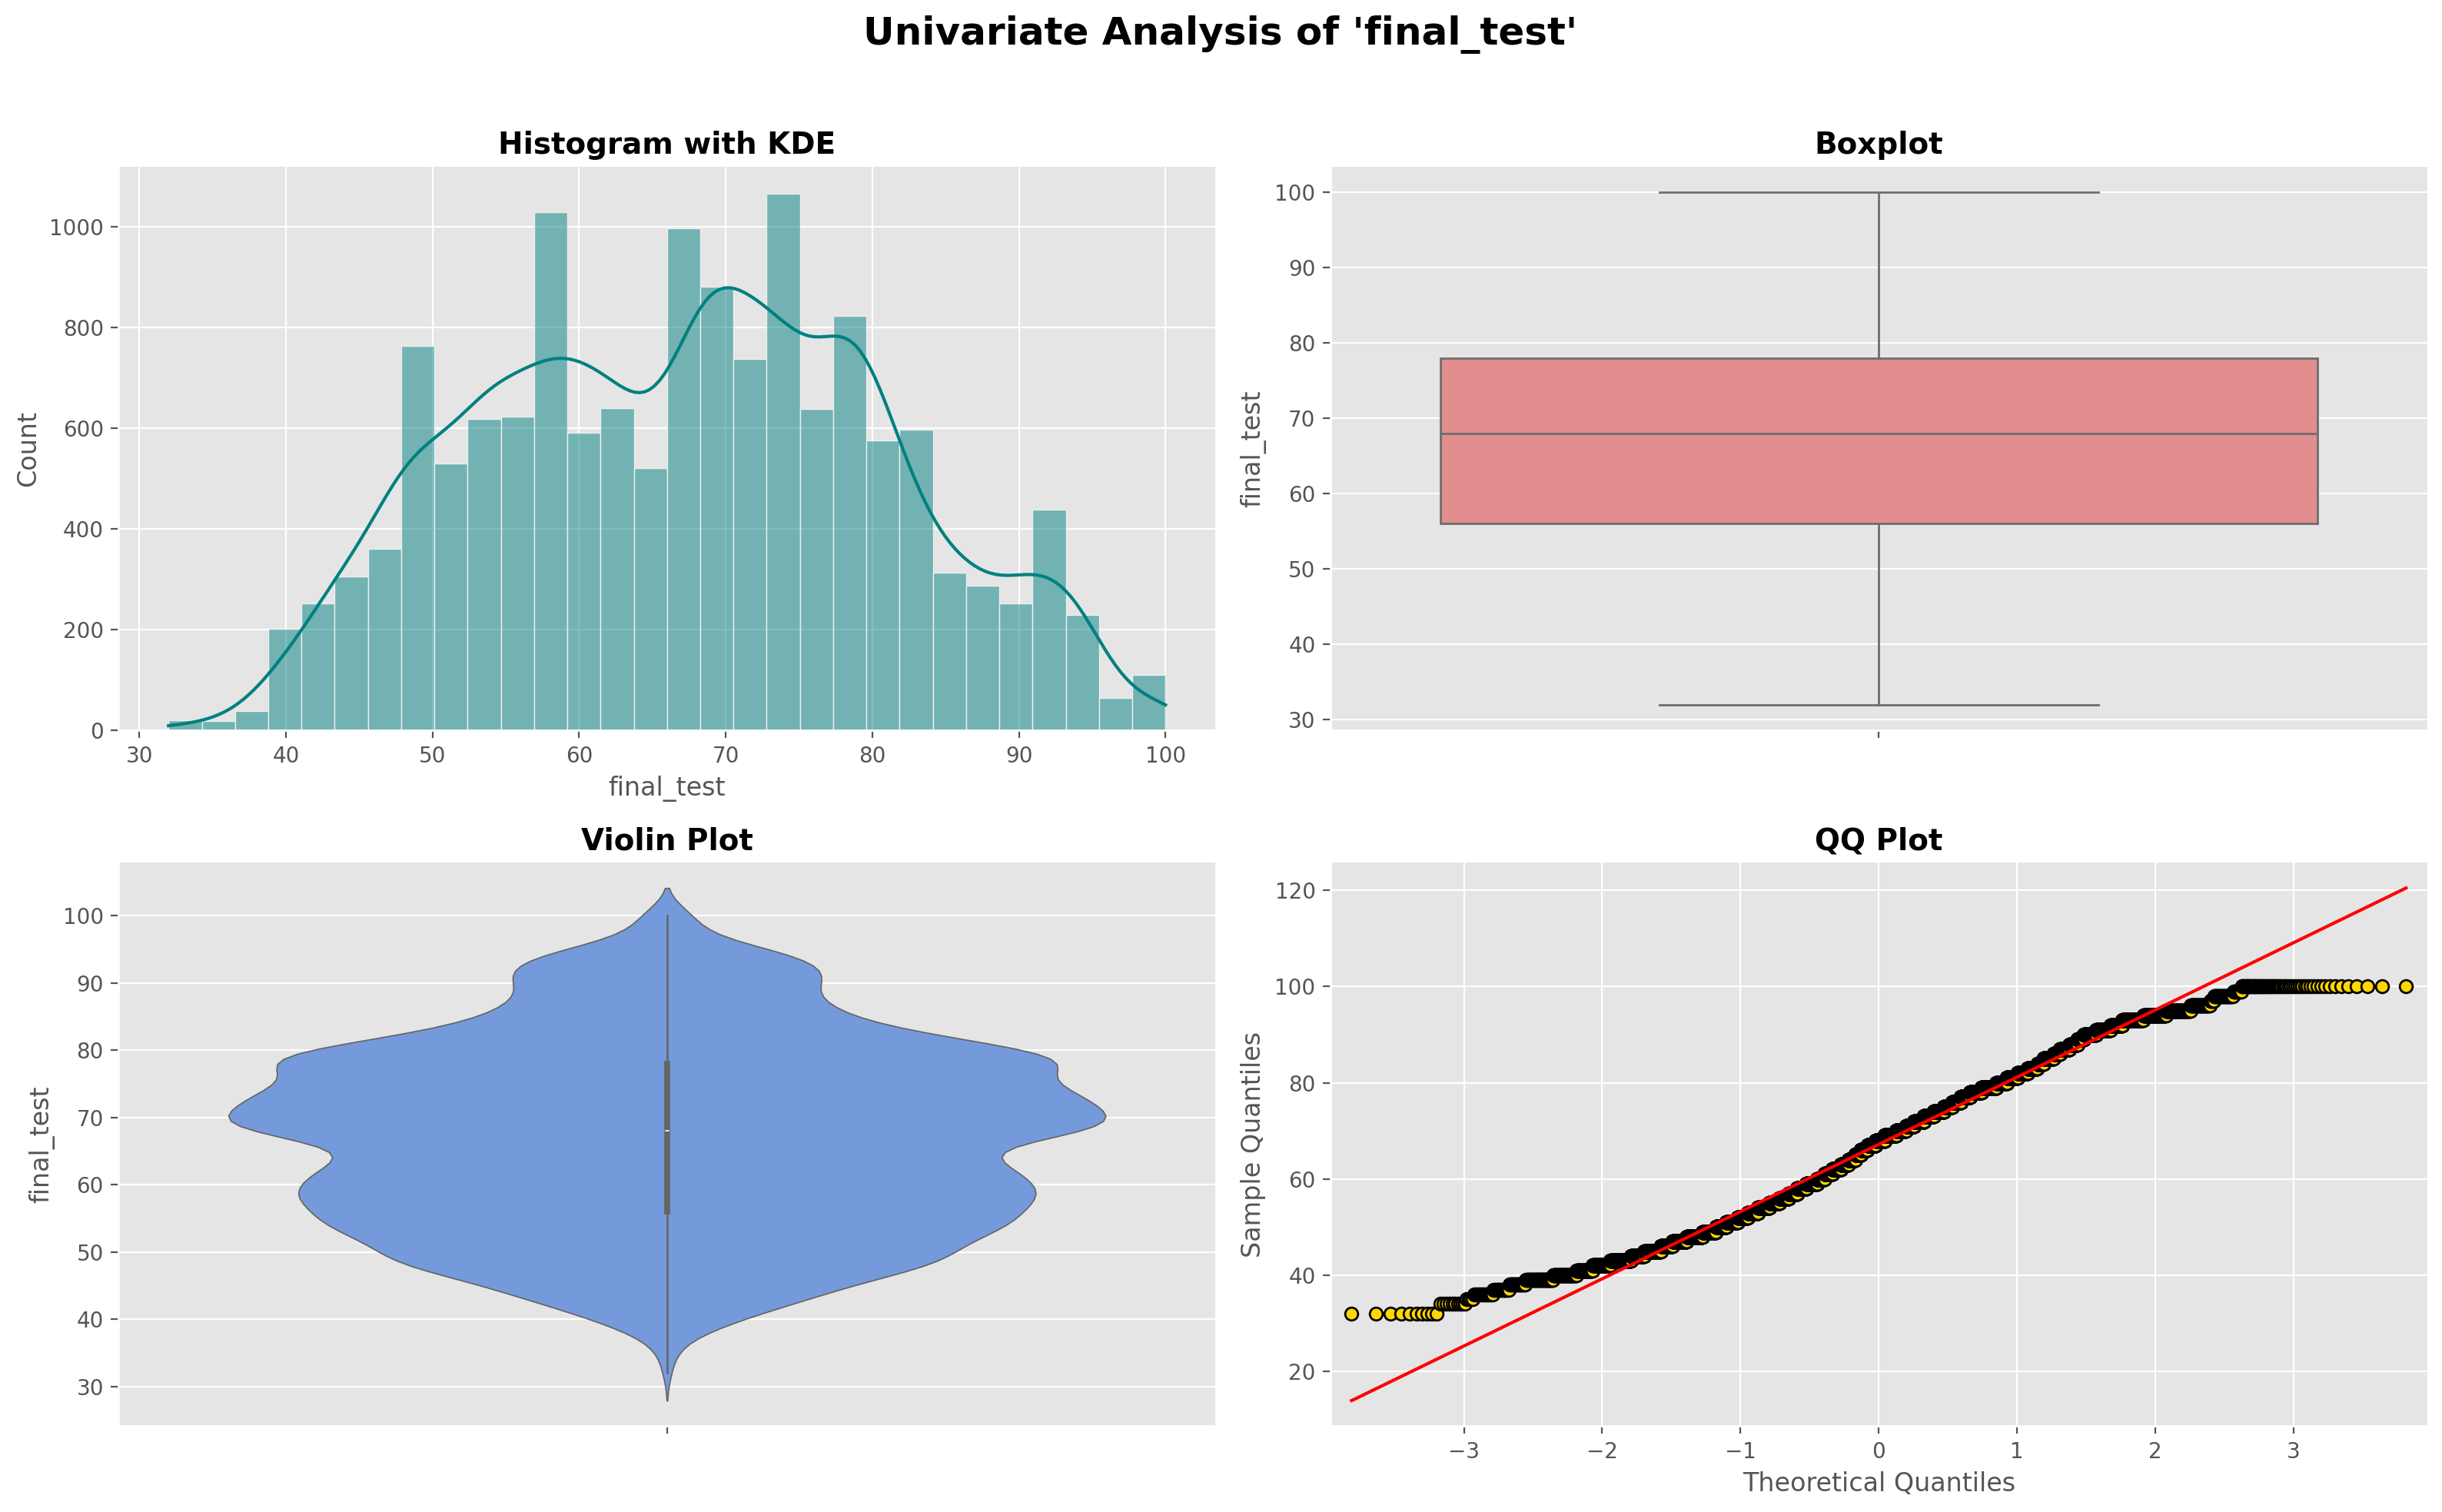

In [33]:
perform_univariate_analysis(df=df_cleaned, column_name=TARGET, show_graphs=True)

**💡 Class Imbalance**

- The target variable `no_show` exhibits a class imbalance, with 63% of customers showing up (0 = Show) and 37% being no-shows (1 = No-Show). While the imbalance is moderate rather than severe, it must still be carefully managed during modeling to ensure accurate predictions and avoid bias toward the majority class.

- To address this imbalance, we will adopt a combination of robust evaluation metrics and ensemble methods, which are particularly well-suited for this dataset. Below is a detailed explanation of the chosen approach, along with reasons for not selecting other potential solutions.

**💡 Model Selection:**

- We will prioritize ensemble methods such as Random Forest , Gradient Boosting (e.g., XGBoost, LightGBM) , or Balanced Random Forest. These methods:

  - Naturally handle class imbalance better than single models.

  - Can incorporate techniques like class weighting internally, without requiring explicit resampling.

  - Are computationally efficient and scalable, making them suitable for the large dataset provided.

**💡 Evaluation Metrics:**

Instead of relying solely on accuracy (which can be misleading in imbalanced datasets), we will focus on more robust metrics that will provide a comprehensive understanding of model performance, especially for the minority class (`No-Show`), which is crucial for reducing expenses incurred due to no-shows: -

  - Precision : Measures the proportion of correctly predicted no-shows out of all predicted no-shows. This is critical for minimizing false positives (e.g., incorrectly predicting a customer as a no-show).

  - Recall (Sensitivity) : Measures the proportion of correctly predicted no-shows out of all actual no-shows. This ensures that we capture as many true no-shows as possible.

  - F1-Score : The harmonic mean of Precision and Recall, providing a balanced measure of both.

  - AUC-ROC : Evaluates the model's ability to distinguish between classes across all thresholds.

  - PR Curve (Precision-Recall Curve) : Particularly useful for imbalanced datasets, as it focuses on the performance of the minority class (no-shows).

**💡Reasons for not choosing other solutions:**

   -  SMOTE (Synthetic Minority Over-sampling Technique)
      - The dataset is already very large, and generating synthetic samples would significantly increase computational costs.
      - SMOTE may introduce noise if the minority class (No-Show) has overlapping characteristics with the majority class (Show), potentially degrading model performance.
      - Given the moderate imbalance (37% vs. 63%), SMOTE is unnecessary and may overcomplicate the solution.

   - Upsampling
      - Upsampling the minority class by duplicating existing samples would artificially inflate its representation, leading to overfitting.
      - For a large dataset like this, upsampling is computationally expensive and unlikely to yield significant improvements over ensemble methods.

   - Downsampling
      - Downsampling the majority class (Show) would discard valuable information, potentially reducing the model's ability to generalize.

   - Cost-sensitive Learning
      - While cost-sensitive learning is effective, not all algorithms natively support it. Implementing it manually can be complex and time-consuming.
      - Ensemble methods like XGBoost and LightGBM inherently support class weighting, making them a more streamlined and efficient choice.
    

**💡 Conclusion  for `no_show`**

- Data type: Int64 - appropriate
- Distribution: More Shows (0)

---
---
## **🧼 6.4. Explore `branch`**

- Hotel branch

---
**📊 Perform univariate analysis**

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='branch', show_graphs=False)

---
**🧼 Clean column**

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['branch'])

---
**📊 Verify column afer cleaning**

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='branch', show_graphs=True)

**💡 Conclusion  for `branch`**

- Data type: object - appropriate
- Distribution: 

---
---
## **🧼 6.5. Explore `booking_month`**

- Month the booking was made by the customer

---
**📊 Perform univariate analysis**

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='booking_month', show_graphs=False)

---
**🧼 Clean column**

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['booking_month'])

---
**📊 Verify column afer cleaning**

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='booking_month', show_graphs=True)

---
---
## **🧼 6.6. Explore `arrival_month`**

- Month the customer plan to arrive at the hotel

---
**📊 Perform univariate analysis**

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='arrival_month', show_graphs=False)

- Seems like the data have different capitalisation issues
- To feedback to data collection team to check if can rectify this error for future cases
- For now, to create a function to deal with these issues

---
**🧼 Clean column**

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['arrival_month'])

---
**📊 Verify column afer cleaning**

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='arrival_month', show_graphs=True)

---
---
## **🧼 6.7. Explore `arrival_day`**

- Day date the customer plan to arrive at the hotel

---
**📊 Perform univariate analysis**

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='arrival_day', show_graphs=False)

---
**🧼 Clean column**

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['arrival_day'])

---
**📊 Verify column afer cleaning**

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='arrival_day', show_graphs=True, show_distribution=True)

---

## **🧼 6.8. Explore `checkout_month`**

- Month the customer plan to checkout of the hotel

<br>

---

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='checkout_month', show_graphs=False)

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['checkout_month'])

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='checkout_month', show_graphs=True)

---

## **🧼 6.9. Explore `checkout_day`**

- Day date the customer plan to checkout of the hotel

<br>

---

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='checkout_day', show_graphs=False, show_distribution=True)

**💡💡💡 Analysis 💡💡💡**

- Seems like the data have an issue with negative number days
- COnfirm with data collection team if it is just a negative sign issue, if so can just modulus it, if not, as all negative are less than 1% each, can choose to remove them
- To feedback to data collection team to check if can rectify this error for future cases
- For now, to create a function to get the absolute value for the negative numbers

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['checkout_day'])

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='checkout_day', show_graphs=True, show_distribution=True)

---

## **🧼 6.10. Explore `country`**

- Nationality of the customer

<br>

---

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='country', show_graphs=False)

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['country'])

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='country', show_graphs=True)

---

## **🧼 6.11. Explore `first_time`**

- If it is the first time customer staying in the hotel

<br>

---

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='first_time', show_graphs=False)

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['first_time'])

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='first_time', show_graphs=True)

---

## **🧼 6.12. Explore `room`**

- Room type booked by the customer

<br>

---

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='room', show_graphs=False)

- Approximately 18% of the dataset contains missing values , which is substantial and cannot be ignored as a one-off anomaly. Leaving these missing values unaddressed could skew the analysis and lead to biased insights.

- Dropping rows with missing data might result in a significant loss of information, potentially undermining the representativeness of the dataset.

- Clarify with data collector
  - Understand the root cause of the missing data.
  - Questions to ask:
    - Is the missing data due to an oversight during data collection (e.g., incomplete fields or system errors)?
    - Could "None" represent a valid category (e.g., a specific room type or booking condition) rather than a true absence of data?
    - Are there technical limitations or constraints that led to these gaps?

- Systematic vs. Random Missingness
  - Are missing values concentrated in specific features (e.g., room type, branch, or booking platform)?
  - Do certain categories or groups exhibit higher rates of missingness?

- If "None" Represents a Valid Category : Retain "None" as a distinct category and encode it appropriately (e.g., using one-hot encoding or ordinal encoding).

- If Missingness is Systematic :
Investigate and address the underlying causes (e.g., operational inefficiencies or data entry issues).
Create derived features to capture patterns in missingness (e.g., flags for missing room types or branches).


- If Missingness is Random :
Apply imputation techniques (e.g., mean/median for numerical features, mode for categorical features) to fill in the gaps.
Alternatively, drop rows with missing values if the proportion of affected data is small and unbiased.


In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['room'])

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='room', show_graphs=True)

---

## **🧼 6.13. Explore `price`**

**Description:**

- Price of the room booked by the customer

**Why `price` is Likely to Be a Good Predictor:**

- **Higher Prices May Indicate Commitment**: Customers who book more expensive rooms may be less likely to miss their bookings because they have a higher financial stake in the reservation. This could reduce the likelihood of no-shows for high-priced bookings.

- **Lower Prices May Lead to Indifference:** Conversely, customers booking cheaper rooms might feel less committed to their reservations, especially if they perceive the cost of cancellation or no-show to be negligible. This could increase the likelihood of no-shows for low-priced bookings.

- **Relationship with Booking Behavior:** Customers booking premium rooms (higher price) may exhibit different behaviors compared to those booking budget rooms. For example, business travelers or affluent customers (who typically book higher-priced rooms) may have stricter schedules and are thus less likely to miss their bookings.

- **Interaction with Other Features:** Price often interacts with other features like room type, platform, and booking month. For instance, rooms booked during peak seasons (with higher prices) might have lower no-show rates due to stricter cancellation policies or higher demand.

- **Potential Non-Linear Relationship:** The relationship between price and no-shows might not be linear. For example, extremely high prices could deter last-minute cancellations, while very low prices might lead to indifference. Exploring this relationship through visualization (e.g., scatterplots, boxplots) and statistical analysis can provide deeper insights.

<br>

---

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='price', show_graphs=False, show_distribution=False)

Type of Model
- Simple Models (e.g., Logistic Regression, Decision Trees):
These models typically require less data because they make strong assumptions about the data distribution.
- Complex Models (e.g., Neural Networks, Gradient Boosting Machines):
These models can benefit from larger datasets to fully leverage their capacity to learn complex patterns. However, 70,000 rows should still be sufficient for most practical applications.

- < 1,000 rows
Risk of overfitting; suitable only for very simple problems or small feature sets.
- 1,000–10,000 rows
Good for small to medium-sized problems with moderate feature sets.
- 10,000–100,000 rows
Ideal for most structured/tabular datasets; sufficient for complex models.
- 100,000 rows
Suitable for large-scale problems, deep learning, or high-dimensional data.


Neural networks may be overkill due to < 100,000 data and also probably wont have much non-linear relationships

Deal with different values, impute with the int '0' first, and convert to float


In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['price'])

print("\nCleaned Price Column:")
display(df_cleaned)

In [ ]:
non_missing_price_mask = df_cleaned['price_in_sgd'] != 0 # To not consider the missing values
perform_univariate_analysis(df=df_cleaned[non_missing_price_mask], column_name='price_in_sgd', show_graphs=True, show_distribution=False)

💡 Quite a bit of outliers as seen from the box plot
- to analyse
- almost normal with right skew
- can choose to remove, transform, or retain
  - Remove Outliers: If outliers are due to data entry errors , measurement errors , or irrelevant noise 
  - Transform: 
    - Log Transformation : Compresses large values
    - Winsorization : Caps extreme values at a certain percentile (e.g., 1st and 99th percentiles).
  - Retain Outliers
    - If outliers are genuine observations that reflect important phenomena,
    - Example: High-income individuals in a salary dataset might represent a valid segment of the population.

- To deal with the missing values later


---

## **🧼 6.14. Explore `platform`**

- Platform used to book the room by the customer

<br>

---

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='platform', show_graphs=False)

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['platform'])

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='platform', show_graphs=True)

---

## **🧼 6.15. Explore `num_adults`**

- Number of adults staying

<br>

---

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='num_adults', show_graphs=False)

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['num_adults'])

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='num_adults', show_graphs=True)

---

## **🧼 6.16. Explore `num_children`**

- Number of children staying

<br>

---

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='num_children', show_graphs=False)

In [ ]:
df_cleaned = clean_data(df=df_cleaned, columns_to_clean=['num_children'])

In [ ]:
perform_univariate_analysis(df=df_cleaned, column_name='num_children', show_graphs=True)

---
## 🧼 **6.X. Review Dataset**

A quick inspection of summary statistics and key distributions confirms the integrity of the data, ensuring it is prepared for exploratory data analysis (EDA) and subsequent modeling stages.

<br>

---

**📊 Review top 5 rows**

In [ ]:
df_cleaned.head()

- The data looks cleaned and ready for further processing and analysis

**📊 Review the summary statistics**

In [ ]:
df_cleaned.info()

- All columns do not have missing value and are all of the appropriate data types

**📊 Review the summary statistics**

In [ ]:
# Display in normal notation instead of scientific
with pd.option_context('float_format', '{:f}'.format):
    df_cleaned.describe()

Since you are comparing the memory usage of two DataFrames (df_original and df_cleaned) and likely want an accurate measurement , you should use deep=True. This ensures that the memory usage reflects the actual size of the data, including object-type columns like strings.

- If your dataset contains object-type columns (e.g., branch, room, country), using deep=False could significantly underestimate the memory usage.
- Using deep=True ensures that your comparison of memory usage between df_original and df_cleaned is reliable and meaningful.

**📊 Run a comparison between the initial and cleaned dataset**

In [ ]:
compare_dataframes(df_original=df, df_new=df_cleaned)

💡 Impact of Dropping Rows and Optimizing Data Types

- Potential Loss of Valuable Information: A significant reduction in the dataset size due to dropped rows may result in the loss of valuable information. This could impact the model's ability to generalize and capture nuanced patterns in the data.

- Trade-offs:
  - Reduced Data Usage: Fewer rows lead to faster training times and lower computational resource requirements, which can be beneficial for efficiency.
  - Optimized Storage: Converting features to more efficient data types (e.g., categories and integers) significantly reduces memory usage, further enhancing performance without compromising functionality.

---
---
#  **✂️ 7. Data Splitting**

To ensure robust and reliable model evaluation, the dataset is split into **training** and **testing** subsets before performing extensive EDA or feature engineering. This step ensures that the evaluation of our models remains unbiased and reflective of real-world performance.

The training set will be used for all subsequent steps, including comprehensive EDA, data preprocessing and feature engineering, while the test set will remain untouched until the final evaluation phase. This separation helps prevent data leakage, ensuring that no information from the test set inadvertently influences the data preprocessing and feature engineering process. By splitting the data early, we mimic real-world conditions where the model must generalize to unseen data. This ensures that our evaluation metrics reflect how the model will perform in production.

While splitting the data before EDA and feature engineering ensures unbiased evaluation, it may result in some patterns or insights present in the test set not being fully captured during model training. However, this trade-off is intentional and necessary. A model that performs well on unseen data is far more valuable than one that achieves high accuracy on the training data but fails to generalize in production.

In [ ]:
from sklearn.model_selection import train_test_split

**⬜ Split the data into training and test sets**

- A stratified split is used to preserve the distribution of the target variable in both the training and testing sets. This is critical given the imbalanced nature of the dataset, where "no-shows" are less frequent than "shows."

- We allocated a configurable test size (`test_size`), currently set at 20%, of the data to the test set, striking a balance between having a sufficiently large training set and a robust evaluation set.

- A fixed random seed (`random_state`) ensures reproducibility by generating consistent training and test datasets in both EDA and the ML pipeline.

In [ ]:
# Separate features and target
y = df_cleaned[TARGET]  # Target variable
X = df_cleaned.drop(columns=[TARGET])  # Feature matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    stratify=y,                  # Ensures the same class distribution in train and test sets, important for imbalanced datasets
    test_size=TEST_SIZE,         # Set in the config.yaml
    random_state=RANDOM_STATE    # To ensure reproducibility as per EDA
)

# Print out shapes
print(f"Training Feature Set Shape: {X_train.shape}")
print(f"Training Target Set Shape: {y_train.shape}")
print(f"Test Feature Set Shape: {X_test.shape}")
print(f"Test Target Set Shape: {y_test.shape}")

**⬜ Combine the training features and target into a DataFrame**

- The training features (`X_train`) and target (`y_train`) are combined into a single DataFrame (`df_train`) for streamlined analysis in further sections.

- Moving forward, only the training set will be used for EDA and feature engineering.

- The test set is set aside and will remain unused for the rest of this EDA to prevent data leakage. Keeping the test set completely separate avoids any information from it influencing EDA, preprocessing, or feature engineering steps. For example, calculating statistics like mean or median imputation on the entire dataset could inadvertently leak information from the test set into the training process.

- This same `train_test_split` configuration will be replicated in the machine learning pipeline to ensure consistency.

In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train

---
---
#  **🗺️ 8. Deep Exploration**

This section focuses on analyzing the relationships between pairs of variables to uncover patterns, dependencies, and interactions that may not be apparent during univariate analysis. By exploring how two features interact, we gain deeper insights into their combined influence on the target variable (e.g., no-show) and identify potential predictors or confounding factors. This step is essential for understanding feature importance, detecting multicollinearity, and informing feature engineering decisions.

To ensure a comprehensive exploration, both numerical and categorical features will be analyzed in pairs using appropriate statistical methods and visualizations. For example:

- Deep Dive into specific features with issues

- Numerical vs. Numerical: Scatterplots, correlation coefficients, and regression analyses will be used to assess linear and non-linear relationships.

- Categorical vs. Numerical: Boxplots, grouped bar charts, and statistical tests (e.g., ANOVA) will evaluate differences in numerical values across categories.

- Categorical vs. Categorical: Crosstabs, stacked bar charts, and chi-square tests will identify associations between categorical variables.


Feature engineering was performed to enhance model performance by creating new, meaningful features and transforming existing ones. These transformations aim to improve model interpretability, reduce multicollinearity, and ensure compatibility with machine learning algorithms.

Focus on adding features, feature removal will be handled in the next section under Feature Selection

Feature Engineering :
Handling missing values.
Encoding categorical variables.
Creating new features based on insights from exploration.
Dropping irrelevant or redundant features.

In [ ]:
from src.preprocess_data import create_months_to_arrival_feature, create_stay_duration_days_feature

In [ ]:
# Create copy of DataFrame
df_train_engineered = df_train.copy()

---
## 🗺️ **8.1. Handle `price_in_sgd` Issues**

As discovered during univariate analysis, there are several issues with the `price_in_sgd` (previously `price`) column.

  - Missing values

  - Outliers

We will address them here to see if they make sense when evaluated with other features.

---
### 🛠️ **8.1.1. Impute missing values**

The ...

**📊 Understand missing values in `price`**

In [ ]:
# Replace 0 values in the 'price_in_sgd' column with NaN
df_train_engineered['price_in_sgd'] = df_train_engineered['price_in_sgd'].replace(0, np.nan)

# Analyse missing values
analyse_missing_values(df=df_train_engineered, column_name='price_in_sgd')

Seems to be Missing at Random ("MAR") as it depends a lot on the currency type

- Based on the provided information, the `currency_type` column has a 34.52% missing proportion for `SGD` and 0.00% missing proportion for `USD`. This indicates that the missingness in the `price_in_sgd` column is strongly correlated with the `currency_type` column , specifically for rows where `currency_type` is `SGD`.

- The high missing proportion for `SGD` suggests that the missingness might not be random. It could indicate a systematic issue or a specific pattern related to `SGD`. Since there are no missing values for `USD`, this further supports the idea that missingness is tied to `currency_type`.

- Given that missingness is strongly correlated with `currency_type` , the most appropriate approach is to use group-based imputation (e.g., mean/median imputation by `currency_type`). This ensures that the imputed values are contextually relevant and respects the underlying patterns in the data.

- Use Median Imputation When:
  - The data is skewed (e.g., long tails in the distribution).
  - There are outliers in the column.
  - You want a robust measure of central tendency that is less affected by extreme values.
  - The median is resistant to outliers and better represents the "typical" value in skewed distributions.
  - It ensures that the imputed values do not distort the overall distribution of the data.

In [ ]:
from src.preprocess_data import impute_missing_values_price_in_sgd

df_train_engineered = impute_missing_values_price_in_sgd(df=df_train_engineered)

In [ ]:
# Verify the results
perform_univariate_analysis(df=df_train_engineered, column_name='price_in_sgd', show_distribution=False)

- No more missing values

- 564 outliers present

**📊 Study how `price` changes with different `room` categories**

In [ ]:
perform_bivariate_analysis(df_train_engineered, 'room', 'price_in_sgd')

- The high ones seems to correlate with presidential suites --> so do not remove the expensive ones, and presidential suites are lesser, so that explains why it appears as outliers, but when u see the scatter plot, it correlates nicely with the room type

- Based on the scatter plot, the others seem to be together, but there seems to be some outliers for the presidential suite, could this be due to data entry? or maybe it is king rooms but incorrectly listed as presidential suite --> to explore them

In [ ]:
# Filter for President Suite
president_suite_data = df_train_engineered[df_train_engineered['room'] == 'President Suite']
president_suite_data_outliers = president_suite_data[president_suite_data['price_in_sgd'] < 1500]
president_suite_data_outliers

- All seems to be Changi, and majority bookings are from CHina, and all are first timers --> Discounts?
- However, there are still some shows, so that means the person actually arrived
- If these low prices are genuine and meaningful (e.g., promotional discounts or special offers), they should be retained.
- However, if they are errors or irrelevant data points, removing them can improve the quality of your dataset.
- Consult domain experts or stakeholders to confirm whether these low prices are valid or indicative of errors.
- Assume that these are only 11 of these, assume that they are either errors, or discounts (which will not apply generally) --> remove them

---
### 🛠️ **8.1.2. Remove outliers**

The ...

In [ ]:
from src.preprocess_data import remove_outliers_price_in_sgd

df_train_engineered = remove_outliers_price_in_sgd(df=df_train_engineered)

In [ ]:
# Verify the result
print(df_train_engineered[df_train_engineered['room'] == 'President Suite']['price_in_sgd'].min())

In [ ]:
perform_bivariate_analysis(df_train_engineered, 'room', 'price_in_sgd')

- No more outliers for price and seems to fit squarely into the various room types

- There are still some issues with the Missing column, we will handle them below

---
## 🗺️ **8.2. Handle `room` Issues**

As discovered during univariate analysis, there are several issues with the `room` column.

  - Missing values

We will address them here to see if they make sense when evaluated with other features.

---
### 🛠️ **8.2.1. Remove missing values**

The ...

In [ ]:
# Replace 0 values in the 'room' column with NaN
df_train_engineered['room'] = df_train_engineered['room'].replace('Missing', np.nan)

# Analyse missing values
analyse_missing_values(df=df_train_engineered, column_name='room')

- Checked through all possible relevant group-by columns, the missing proportion is all the same, this means that this error is common

- If after confirming with data collector, that this is not another room, like double etc., and it is purely random, to remove

- For our case, we assume that it is purely random, and since it is alot, we impute as 'Missing' first

- `room` is evenly distributed --> `room` is MCAR (Missing Completely at Random) --> missing values are completely random and unrelated to other features, simpler methods like mean/median imputation are sufficient. (avoid KNN, which fairs better when it is Missing At Random (MAR) but correlated with other features)

- missing values are completely random and unrelated to other features, simpler methods like mean/median imputation are sufficient.

- Use Use Mean Imputation When:
  - The data is normally distributed (i.e., symmetric with no significant skewness).
  - There are no extreme outliers in the column.
  - You want to preserve the overall mean of the dataset.
  - The mean represents the central tendency of the data and works well when the distribution is symmetric.
  - However, the mean is sensitive to outliers, so it may not be ideal for skewed distributions.

- Use Median Imputation When:
  - The data is skewed (e.g., long tails in the distribution).
  - There are outliers in the column.
  - You want a robust measure of central tendency that is less affected by extreme values.
  - The median is resistant to outliers and better represents the "typical" value in skewed distributions.
  - It ensures that the imputed values do not distort the overall distribution of the data.

- Also, to tell data collector to fix this, so that in the future will have sufficient data



In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1='room', col2='price_in_sgd')

- Given that there is a large complete variance of the price for the missing rooms (from the bivariate scatter plot with jitter between `price` and `room`) --> it suggests that these missing rooms represent all the other room types, suggesting that it is just missing completely at random and not dependent on a specific type of room

- To remove these rows

- Your dataset has 16 attributes , which is a moderate number of features. With 70,000 rows, you have a good ratio of samples to features, reducing the risk of overfitting.
- As a rule of thumb, having at least 10–20 times as many samples as features is desirable. In your case:
70,000 rows / 16 features ≈ 4,375 samples per feature , which is excellent.

In [ ]:
from src.preprocess_data import remove_missing_values_room

# Drop rows with missing values in the 'room' column
df_train_engineered = remove_missing_values_room(df=df_train_engineered)

In [ ]:
perform_univariate_analysis(df=df_train_engineered, column_name='room')

---
## 🗺️ **8.3. Numerical Interactions**

The `pairplot` provides a comprehensive view of relationships between numerical features while highlighting differences based on the `no_show` status (0 = Show, 1 = No-Show). By using `no_show` as the hue, the visualization reveals how numerical features like `price`, `num_adults`, and `num_children` vary between customers who showed up and those who did not. 

**📊 Use a pairgrid to study the relationship between numerical features**

In [ ]:
# Create PairGrid
g = sns.PairGrid(data=df_train_engineered, hue=TARGET, palette='inferno', diag_sharey=False)

# Diagonal: Histograms with KDE
g.map_diag(sns.histplot, kde=True, bins=20, alpha=0.7, stat='density')

# Upper triangle: Scatter plots with regression lines
g.map_upper(sns.regplot, scatter_kws={'alpha': 0.25, 'edgecolor':'white'}, line_kws={'color': 'red', 'linewidth': 1.5})

# Lower triangle: Scatter plots
g.map_lower(sns.scatterplot, alpha=0.5, edgecolor='white')

# Add a legend
g.add_legend(title=TARGET, loc='upper right', bbox_to_anchor=(1.2, 1), frameon=True, edgecolor='black')

# Adjust layout and add title
plt.suptitle("Pairwise Relationships Between Numerical Features", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- No significant relationships between numerical variables

- Although there is an empty zone for price when plotting against `arrival_day` and `checkout_day`, which coincides with our understanding that there are presidential suites that are significantly more expensive than the other room types.

**📊 Use a correlation heatmap**

In [ ]:
# Select only numeric columns
numerical_features = df_train_engineered.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numerical_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14, fontweight="bold")
plt.show()

- There seems to be a moderately strong positive correlation between arrival day and checkout day
- Neither arrival day and checkout day has a relevant correlation with price

---
## 🗺️ **8.4. Target-Variable Relationships**

- Countplot, Proportion Table
- Analyze how the target variable `no_show` relates to other features.
- For instance, visualizing the proportion of no-shows (no_show) across different booking platforms (platform) can reveal which platforms are more prone to cancellations.

---
**📊 Target analysis sandbox**

- This section allows you to play around with different features and see how they interact with the target variable.

- Notable interactions are detailed in the following code blocks.

In [ ]:
# Amend col1 for desired bivariate analysis
col1 = 'room'

perform_bivariate_analysis(df_train_engineered, col1=col1, col2="no_show")

---
**📊 `branch` vs `no_show`**

- Certain countries may show patterns in no-show rates

In [ ]:
perform_bivariate_analysis(df_train_engineered, col1="branch", col2="no_show")

- Seems like Orchard has significantly more no-shows (72.4%) as compared to Changi --> this is also statistically significant with a moderate effect
- Keep the feature in

---
**📊 `price` vs `no_show`**

- Certain countries may show patterns in no-show rates

In [ ]:
perform_bivariate_analysis(df_train_engineered, col1="price_in_sgd", col2="no_show")

- Interestingly, price does not have a strong correlation with no-show rates, even though it would be intuitive that the more expensive the room is, the less likely people are to no-show it
- Despite the weak correlation, the fact that the relationship is statistically significant suggests there might still be some predictive power in price, even if it’s minimal.
- Intuitively, price could still play a role in predicting no_show. For example: Higher-priced rooms might influence customer behavior differently than lower-priced ones. Removing price entirely might overlook subtle interactions or patterns.
- In machine learning models, features with weak correlations can still improve performance when combined with other features. Removing price prematurely might lead to information loss.

In [ ]:
perform_bivariate_analysis(df_train_engineered, col1="price_in_sgd", col2="room")

Although price and room are highly correlated, we will retain both features because price captures additional variability within each room type. For example, a 'King' room may have different prices depending on factors such as location, season, or discounts. This variability might influence the likelihood of a no-show independently of the room type. Furthermore, preliminary analysis shows significant price ranges within each room type (e.g., 'King' rooms have a standard deviation of $X), suggesting that price provides complementary information to room. Retaining both features ensures that our model can leverage this granularity to improve predictive performance.

In [ ]:
perform_multivariate_analysis(df_train_engineered, col1="checkout_day", col2="arrival_day", col3="price_in_sgd")

---
**📊 Country vs no-show rates**

- Certain countries may show patterns in no-show rates

In [ ]:
perform_bivariate_analysis(df_train_engineered, col1="country", col2="no_show")

- It seems like China has the most no-shows with 57% of all bookings resulting in no shows. Malaysia is a close second, while the other countries are around the same level
- There low p value and Cramer's V value also indicates a moderate to strong association
- To retain this feature

---
## 🗺️ **8.5. Temporal Trends**

- Features: `booking_month`, `arrival_month`, `arrival_day`, `checkout_month`, `checkout_day`

- As di

In [ ]:
# Uncomment to check various month types
month_to_check = 'booking_month'
# month_to_check = 'arrival_month'
# month_to_check = 'checkout_month'

perform_bivariate_analysis(df=df_train_engineered, col1=month_to_check, col2='no_show')

- There are slight variations but there does not seem to be extreme patterns between holiday seasons (e.g. December, June) as compared to other months
- 💡 There does not seem to be seasonal trends affecting no show results
- Same applies for checkout month and arrival month
- May consider removing these columns and creating new features that deals with lead time and time to checkout etc.


---
### 🛠️ **8.5.1. Create `months_to_arrival`**

The `months_to_arrival` column is a derived feature that calculates the time gap (in months) between the booking month and the arrival month. This feature is valuable for several reasons:

- Captures Customer Behavior Patterns:

  - The time between booking and arrival can reveal insights into customer planning behavior. For example, short gaps (e.g., 0–2 months) may indicate last-minute bookings while longer gaps (e.g., 6–12 months) may suggest advance planning or seasonal preferences.
  
  - These patterns can be predictive of outcomes like no-shows, cancellations, or customer loyalty.

In [ ]:
df_train_engineered = create_months_to_arrival_feature(df=df_train_engineered)
df_train_engineered

In [ ]:
perform_univariate_analysis(df=df_train_engineered, column_name='months_to_arrival', show_distribution=True)

- Most booking months are within that month of arrival, with a general gradual decrease as the months increases

In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1="months_to_arrival", col2="no_show")

- Seems like for people who no-show, the number of months from the booking month before arrive is genrally higher

---
### 🛠️ **8.5.2. Create `stay_duration_days`**

The stay_duration_days column is a derived feature that calculates the total duration of a guest's stay in days, based on the arrival and checkout dates. This feature is valuable for several reasons:

- Captures Customer Preferences:

  - The length of stay can provide insights into customer preferences and behaviors. For example, shorter stays (e.g., 1–3 days) may indicate business travelers, while longer stays (e.g., 7+ days) may suggest vacationers or extended visits.

  - These patterns can help predict outcomes such as booking cancellations, no-shows, or repeat bookings.

In [ ]:
df_train_engineered = create_stay_duration_days_feature(df=df_train_engineered)
df_train_engineered

In [ ]:
perform_univariate_analysis(df=df_train_engineered, column_name='stay_duration_days', show_distribution=True)

- Majority just stay for 1-2 days
- To remove this column as a lot of outliers after creating bins


---
### 🛠️ **8.5.3. Create `stay_category`**

- Split up the data to 3 bins, according to stay duration
  - Short term (1-3 days)
  - Mid term (4-14 days)
  - Long term (>14)

In [ ]:
long_duration_stays_mask = df_train_engineered['stay_duration_days']>14
long_duration_stays_df = df_train_engineered[long_duration_stays_mask]
long_duration_stays_df

In [ ]:
short_duration_stays_mask = df_train_engineered['stay_duration_days']<3
short_duration_stays_df = df_train_engineered[short_duration_stays_mask]
short_duration_stays_df

In [ ]:
from src.preprocess_data import create_stay_category_feature

df_train_engineered = create_stay_category_feature(df=df_train_engineered)
df_train_engineered

In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1='no_show', col2='stay_category')

- There seems to be


---
## 🗺️ **8.6. Customer Demographics**

- Features: `first_time`, `country`, `num_adults`, `num_children`

- asda

In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1='first_time', col2='price_in_sgd')

- First timers typically spend lesser on average than those non-first timers

- There are lesser people opting for presidential suites (the higher prices) for the second time, most people opting for the presidential suites are first-timers, could be they just want to have the experience once?

In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1='num_adults', col2='price_in_sgd')

- Generally, more adults means higher prices

---
### 🛠️ **8.6.1. Create `has_children`**

The has_children column is a binary feature derived from the num_children column, indicating whether a booking includes children (1) or not (0). This feature is valuable for several reasons:

Captures Family Dynamics :
The presence of children in a booking can reveal insights into customer behavior and preferences. For example, bookings with children may indicate family vacations, which could influence decisions like room type, stay duration, or amenities required.
These patterns can help predict outcomes such as no-shows, cancellations, or specific service needs.

In [ ]:
from src.preprocess_data import create_has_children_feature 

df_train_engineered = create_has_children_feature(df=df_train_engineered)
df_train_engineered

In [ ]:
perform_univariate_analysis(df=df_train_engineered, column_name='has_children')

In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1=TARGET, col2='has_children')

---
### 🛠️ **8.6.2. Create `total_pax`**

- Total number of guests
- Adults + children


In [ ]:
from src.preprocess_data import create_total_pax_feature

df_train_engineered = create_total_pax_feature(df=df_train_engineered)
df_train_engineered

In [ ]:
perform_univariate_analysis(df=df_train_engineered, column_name='total_pax')

In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1=TARGET, col2='total_pax')

- the percentages for no-show rates between each pax range is very similar

---
## 🗺️ **8.7. Booking Details**

- Features: `branch`, `room`, `price`, `platform`

- ad

In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1='branch', col2='price_in_sgd')

**└── 💡 Observations / Analysis / Insights ───** 

- Seems like Orchard is generally more expensive, which makes sense as Orchard is in town

In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1='branch', col2='room')

**└── 💡 Observations / Analysis / Insights ───** 

- Presidential suites are solely in orchard, and they are very few
- Proportions of rooms vary very differently depending on branches

In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1='branch', col2='country')

**└── 💡 Observations / Analysis / Insights ───** 

- Slight differences but mainly similar distribution 
- We can tell that the proportions of Australians and Chinese are higher for the orchard branch, may imply a slight preference of these nationalities for the Orchard branch

In [ ]:
perform_bivariate_analysis(df=df_train_engineered, col1='branch', col2='platform')

**└── 💡 Observations / Analysis / Insights ───** 

- Different branches may utilize different platforms

- For example, understanding if booking platforms (platform) differ significantly across hotel branches (branch) can reveal operational insights.

- For example, if certain combinations of branch and platform show strong associations with no-shows, these interactions can be encoded as new features for predictive models.

---
## 🗺️ **8.8. Other Feature Interactions**

- This section allows you to play around with different features and see how they interact with the each other.

- Notable interactions are detailed in the following code blocks.


**📊 Feature interaction sandbox**

---
## 🗺️ **8.X. Review Dataset**


**⬜ Inspect new DataFram**

In [ ]:
df_train_engineered

**⬜ Compare DataFrames**

In [ ]:
compare_dataframes(df_original=df_train, df_new=df_train_engineered)

---
---
# ⚙️ **9. Data Preprocessing**

Feature engineering was performed to enhance model performance by creating new, meaningful features and transforming existing ones. These transformations aim to improve model interpretability, reduce multicollinearity, and ensure compatibility with machine learning algorithms.

Focus on adding features, feature removal will be handled in the next section under Feature Selection

- Processes the data to include feature scaling and categorical encoding

In [ ]:
# Create copy of DataFrame
df_train_preprocessed = df_train_engineered.copy()

---
## ⚙️ **9.1. Drop Features**

- These features do not provide predictive power either due to analysis or logical flow
- To remove, if not creates noise
- Some are precursors for additional features created in the prior section


In [ ]:
features_to_drop = [
    "arrival_day",          # Granular detail with low predictive power; better represented by arrival_month.
    "checkout_day",         # Similar to arrival_day, offers limited value; can be redundant with broader temporal features.
    "stay_duration_days",   # Redundant if checkout_date and arrival_date are already considered; may add noise.
    "num_children"          # Most
]

df_train_preprocessed = df_train_preprocessed.drop(columns=features_to_drop, errors='ignore')
df_train_preprocessed

---
## ⚙️ **9.2. Preprocess Data**

- Change data to format for machine learning model can utilise
- So can do further feature analysis and feature selection in next section
- Use scalers and encoders to convert features into machine learning readable formats

- Feature scaling is required as we will be using gradient-based models that will require numerical features to be scaled properly (other tree based models used will not need this, but it does not harm this as well)


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

**⬜ Separate features and target**

In [ ]:
y_train_preprocessed = df_train_preprocessed[TARGET]  # Target variable
X_train_preprocessed = df_train_preprocessed.drop(columns=[TARGET])  # Feature matrix

print(f"Target shape: {y_train_preprocessed.shape}")
print(f"Features shape: {X_train_preprocessed.shape}")

**⬜ Define numerical and categorical features**

In [ ]:
numerical_features = X_train_preprocessed.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train_preprocessed.select_dtypes(include=['object', 'category']).columns.tolist()

X_train_preprocessed_numerical = X_train_preprocessed[numerical_features]
X_train_preprocessed_categorical = X_train_preprocessed[categorical_features]

print(f"Numerical features shape: {X_train_preprocessed_numerical.shape}")
print(f"Categorical features shape: {X_train_preprocessed_categorical.shape}")

**⬜ Apply feature scaling to numerical features**

- Use standard scaler .. why

In [ ]:
scaler = StandardScaler()
X_train_preprocessed_numerical = scaler.fit_transform(X_train_preprocessed_numerical)
X_train_preprocessed_numerical = pd.DataFrame(X_train_preprocessed_numerical, columns=scaler.get_feature_names_out())

print("Scaled numerical features:")
X_train_preprocessed_numerical

**⬜ Apply categorical encoding to categorical features**

- Use One Hot Encoder .. why

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_preprocessed_categorical = encoder.fit_transform(X_train_preprocessed_categorical)
X_train_preprocessed_categorical = X_train_preprocessed_categorical.toarray()
X_train_preprocessed_categorical = pd.DataFrame(X_train_preprocessed_categorical, columns=encoder.get_feature_names_out())

print("Encoded categorical features:")
X_train_preprocessed_categorical

---
## ⚙️ **9.3. Review Dataset**


**⬜ Combine numerical and categorical features with target**

In [ ]:
X_train_preprocessed = X_train_preprocessed.reset_index(drop=True)
y_train_preprocessed = y_train_preprocessed.reset_index(drop=True)
df_train_preprocessed = pd.concat([X_train_preprocessed_numerical, X_train_preprocessed_categorical, y_train_preprocessed], axis=1)
df_train_preprocessed

**⬜ Compare dataframes**

In [ ]:
compare_dataframes(df_original=df_train, df_new=df_train_preprocessed)

**⬜ Separate features and target variable**

In [ ]:
X_train_preprocessed = df_train_preprocessed.drop(columns=[TARGET])  # Features
y_train_preprocessed = df_train_preprocessed[TARGET]  # Target variable

print(f"Target shape: {y_train_preprocessed.shape}")
print(f"Features shape: {X_train_preprocessed.shape}")

---
---
# 🧺 **10. Feature Selection**

Feature selection is a critical step in the machine learning pipeline that aims to identify and retain the most relevant features while removing redundant, irrelevant, or noisy ones. This process not only improves model performance but also enhances interpretability, reduces training time, and mitigates the risk of overfitting.

The primary goals of feature selection in this project include:

1. **Improving Model Performance:** By focusing on the most informative features, the model can generalize better to unseen data.

2. **Reducing Dimensionality:** Removing unnecessary features minimizes computational overhead and simplifies the model.

3. **Enhancing Interpretability:** A smaller set of features makes it easier to understand the relationships between variables and their impact on the target variable.

4. **Mitigating Multicollinearity:** Highly correlated features can distort model coefficients and reduce stability. Feature selection helps address this issue.

In this project, feature selection was conducted systematically using both **unsupervised** and **supervised** techniques to ensure that the final dataset used for modeling is concise, meaningful, and optimized for predictive accuracy: -

- **Unsupervised Techniques**

  - Techniques: `Variance Threshold`, `Correlation Analysis`

  - These methods do not rely on the target variable and are primarily used to remove features with low variability or redundancy

- **Supervised Techniques**

  - Techniques: `Correlation Analysis`, `Recursive Feature Elimination (RFE)`, `Permutation Importance`

  - These methods leverage the relationship between features and the target variable to rank or select the most important features

By combining both unsupervised and supervised feature selection techniques, this project ensures a comprehensive approach to identifying the most relevant features while addressing issues such as redundancy, multicollinearity, and noise. The resulting feature set is optimized for both predictive accuracy and interpretability, laying a strong foundation for subsequent modeling steps.

These techniques cover a broad spectrum of feature selection strategies, including filter methods (Variance Threshold, Correlation Analysis), wrapper methods (RFE), and model-based methods (Permutation Importance). This diversity is a strong point.

- Use Variance Threshold to remove constant or near-constant features.
- Use Correlation Analysis to identify multicollinearity and redundancy.
- Use RFE or Permutation Importance to rank features based on their contribution to model performance.

Dont use PCA as it may not preserve the interpretability of the original features and may not be suitable for non-linear relationships between features.

Feature selection is a tool to help you narrow down and prioritize the most relevant features, but it doesn't mean you must rigidly remove everything below a certain cutoff. The decision to retain or remove features should depend on several factors, including domain knowledge, model performance, and interpretability.

Using the above, but after that will utilise domain knowledge as well

Even if a feature has low variance, low correlation, or low importance according to automated methods, it might still be valuable based on domain expertise or business logic. For example:

- Rare events: A feature like customer_complaint might have low variance because complaints are rare, but they could be highly predictive of no-show behavior.

- Interactions: Some features might interact with others in non-linear ways that aren’t captured by simple metrics like correlation or feature importance.

- Regulatory or ethical considerations: Certain features might need to be retained for compliance or fairness reasons, even if they’re not highly predictive.

In [ ]:
# Create copy of DataFrame
df_train_selected = df_train_preprocessed.copy()

# Extract features and target
X_train_selected = df_train_selected.drop(columns=[TARGET])
y_train_selected = df_train_selected[TARGET]     

# Extract feature names
feature_names = X_train_selected.columns.tolist()

---
## 🧺 **10.1. Variance Threshold**

Variance threshold is an unsupervised feature selection technique that removes features with variance below a specified threshold. Features with very low variance (e.g., constant or near-constant values) are unlikely to contribute meaningfully to the model and can be safely removed.

- Demonstrates your ability to identify and remove features with little to no variability.

- Highlights your understanding of removing noise and redundancy in the dataset.

In [ ]:
# Import function
from sklearn.feature_selection import VarianceThreshold

**⬜ Perform variance-threshold analysis**

- Do not automatically remove features with low variance as even though low variance, may still have predictive capabilities based on domain knowledge

- E.g. presidential suites, although low variance, still probably have some predictive capabilities, as those are more expensive as well

In [ ]:
# Set the variance threshold
threshold = 0.01  # Define the variance threshold

# Initialize VarianceThreshold
selector = VarianceThreshold(threshold=threshold)  

# Fit the selector to calculate variances (without transforming the data)
selector.fit(X_train_preprocessed)

# Get the removed features
original_features = X_train_preprocessed.columns
selected_features = X_train_preprocessed.columns[selector.get_support()]
low_variance_features = list(set(original_features) - set(selected_features))

print(f"✔️ {len(selected_features)} features met variance thresholding")
print(f"⚠️ {len(low_variance_features)} features with low variance (<{threshold}):")
print(low_variance_features)

**⬜ Analyse specific features to verify relevance**

In [ ]:
X_train_preprocessed['total_pax_5'].value_counts()

**└── 💡 Observations / Analysis / Insights ───** 

- Even if a feature has low variance, it doesn't necessarily mean that it is irrelevant or should be removed.

- Low-variance features can still provide valuable information, especially in cases where they interact with other features or have domain-specific importance. 

- Choose to keep all as even though low variance, some of it is due to to the rare case of presidential suites

└─────────────────────────────────────────────────

---
## 🧺 **10.2. Correlation Analysis**

Correlation analysis identifies redundant features by measuring the strength of relationships between variables. Removing highly correlated features reduces multicollinearity, which can distort coefficients in linear models or lead to overfitting.

- Shows your ability to assess feature-target relationships and detect multicollinearity among features.

- Provides insights into both supervised (target correlation) and unsupervised (feature-feature correlation) relationships.

**⬜ Calculate correlation matrix**

In [ ]:
correlation_matrix = df_train_selected.corr()

**⬜ Extract correlations with the target variable**

In [ ]:
target_correlations = correlation_matrix[TARGET].drop(TARGET)
print("🕸️ Correlation of features with the target variable:")
print(target_correlations.sort_values(ascending=False))

**└── 💡 Observations / Analysis / Insights ───** 

- There are no highly correlated features with the target
- The highest is `country_China` which only has a correlation of only 0.335
- Additionally, the second all seems to be at ~0.1
- May need to do more feature engineering to create more features

**⬜ Identify strong correlations with the target variable**

In [ ]:
# Define threshold
strong_correlation_threshold = 0.1

# Identify features with strong positive/negative correlations
strong_correlations = target_correlations[abs(target_correlations) >= strong_correlation_threshold]
print(f"⬆️ {len(strong_correlations)} features with strong correlations (|r| >= {strong_correlation_threshold}) with Target:")
strong_correlations

**└── 💡 Observations / Analysis / Insights ───** 

- The stronger ones are also not that strong

**⬜ Identify weak correlations with the target variable**

In [ ]:
# Define threshold
weak_correlation_threshold = 0.005

# Identify features with weak positive/negative correlations
weak_correlations = target_correlations[abs(target_correlations) < weak_correlation_threshold]
print(f"⬇️ {len(weak_correlations)} features with weak correlations (|r| < {weak_correlation_threshold}) with Target:")
weak_correlations

**└── 💡 Observations / Analysis / Insights ───** 

- Ther

**⬜ Identify highly correlated feature pairs**

In [ ]:
correlation_threshold = 0.8

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print(f"🕸️ Highly correlated feature pairs (|r| > {correlation_threshold}):\n")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

**└── 💡 Observations / Analysis / Insights ───** 

- The encoded variables from the same features, it is expected for them to have perfect / strong negative correlations - To ignore those

- For those not binary encoded (e.g. arrival_months and checkout_months), to remove the checkout_months, as which checkout month they have is less important on when the arrival month is, and since most stays are short term, the months will probably be the same --> to remove the checkout months

---
### 🛠️ **10.2.1. Remove `checkout_month` features**

- Total number of guests
- Adults + children


In [ ]:
# Drop columns
columns_to_drop = [
    "checkout_month_January", "checkout_month_February", "checkout_month_March",
    "checkout_month_April", "checkout_month_May", "checkout_month_June",
    "checkout_month_July", "checkout_month_August", "checkout_month_September",
    "checkout_month_October", "checkout_month_November", "checkout_month_December",  
]
df_train_selected = df_train_selected.drop(columns=columns_to_drop, errors='ignore')

# Check for columns containing "checkout_month"
checkout_month_columns = df_train_selected.filter(like="checkout_month", axis=1)

if checkout_month_columns.empty:
    print("✅ No 'checkout_month...' columns found in the DataFrame.")
else:
    print(f"❌ Found the following 'checkout_month...' columns: {list(checkout_month_columns.columns)}")

df_train_selected

---
## 🧺 **10.3. Recursive Feature Elimination (RFE)**

RFE is a supervised method that recursively removes the least important features based on model performance. It uses a model's feature importance scores or coefficients to iteratively prune the feature set until the desired number of features is reached.

- Demonstrates your ability to use model-based importance scores for feature ranking and selection.

- Highlights iterative refinement of feature sets based on predictive power.

In [ ]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

**⬜ Linear relationship analysis using `LogisticRegression`**

- This will take a while, comment out to run the code

In [ ]:
# # Define the model
# lr_model = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)

# # Initialize and fit RFE
# lr_rfe = RFE(estimator=lr_model, step=1)
# lr_rfe.fit(X_train_selected, y_train_selected)

# feature_rankings = pd.Series(lr_rfe.ranking_, index=X_train_selected.columns).sort_values()
# print("🏆 Feature Rankings:")
# print(feature_rankings)

**└── 💡 Observations / Analysis / Insights ───** 

- asd


In [ ]:
# lr_rfecv = RFECV(estimator=lr_model, step=1, cv=3, scoring='f1')
# lr_rfecv.fit(X_train_selected, y_train_selected)

# print(f"Optimal number of features: {lr_rfecv.n_features_}")

**⬜ Non-linear relationship analysis using `RandomForestClassifier`**

- This will take a while, comment out to run the code

In [ ]:
# # Define the base model
# rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

# # Initialize and fit RFE
# rfe = RFE(estimator=rf_model, step=1)
# rfe.fit(X_train_selected, y_train_selected)

# feature_rankings = pd.Series(rfe.ranking_, index=X_train_selected.columns).sort_values()
# print("🏆 Feature Rankings:")
# print(feature_rankings)

**└── 💡 Observations / Analysis / Insights ───** 

 - asd

In [ ]:
# rfecv = RFECV(estimator=rf_model, step=1, cv=3, scoring='f1')
# rfecv.fit(X_train_selected, y_train_selected)

# print(f"Optimal number of features: {rfecv.n_features_}")

---
## 🧺 **10.4. Permutation Importance**

Permutation importance measures the impact of each feature on model performance by shuffling its values and observing the change in metrics (e.g., accuracy, F1-score). This method works for any model, including those without built-in feature importance scores (e.g., Logistic Regression).

- Adds a robust, model-agnostic approach to evaluating feature importance.

- Demonstrates your ability to validate feature importance beyond intrinsic model metrics (e.g., coefficients or Gini importance).

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
# # Compute permutation importance
# perm_importance = permutation_importance(
#   estimator=rf_model, 
#   X=X_train_selected, y=y_train_selected,
#   scoring="f1", n_repeats=10, random_state=42, n_jobs=-1
# )

# # Convert results to a pandas Series
# perm_importance_scores = pd.Series(perm_importance.importances_mean, index=feature_names).sort_values(ascending=False)

# perm_importance_scores

---
---
# 🚀 **11. Conclusion & Next Steps**

- General cleaning (Carried out above for better exploration, need to replicate in the e2e pipeline)
- Preprocessing steps (To be added to the pipeline)
- To search online to match Singapore holidays with dates to determine if the arrival_day and arrival_month coincides with holidays --> can create a new feature called `is_holiday`
- To get the year, so can better understand if weekend, and match with public holidays for more features
- As we dont know the year, we cant do alot of things to find out the days, weekends, etc. as the day will change based on the specific year